In [1]:
import os
import shutil
import uuid
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
from IPython.display import HTML
from scipy import stats
from scipy.stats import spearmanr
from joblib import Parallel, delayed
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf
from nilearn.glm.first_level import spm_time_derivative
from nilearn import image, masking
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import expression_to_contrast_vector,second_level
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn import plotting
from glob import glob
import matplotlib.colorbar as mpl_colorbar
import matplotlib.pyplot as plt
import seaborn as sns

/panfs/jay/groups/2/feczk001/mdemiden/analyses/mid_rt_bold/.venv/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


This notebook covers the RT modeling sequence for the ABCD Study [Casey et al. 2018](www.doi.org/10.1016/j.dcn.2018.03.001) `Year2` MID task data. The RT framework is based on the theortical paradox described and simulated in [Mumford et al. 2023](www.doi.org/10.1038/s41562-023-01760-0) and previously demonstrated in n = 120/50 3-back working memory task and in n = 26 decision-making task [Yarkoni et al. 2009](www.doi.org/10.1371/journal.pone.0004257). 

In the current modeling of the MID task, consistent with prior litearture, we use several different models that model the Anticipatiory, Feedback and/or Probes phases. The Anticipatory model can be characterized in several different ways. However, traditionally in recent designs it has been defined as the onset and duration (2000ms) of the Cue stimulus (Loss/gain $5 or $0.20 and Neutral). The Feedback phase is typically modeled as associated hit/miss feedback trails for each trial type (Loss/gain $5 or $0.20 and Neutral).

In this effort, we evaluate several versions of the MID models.

1. CueYesDeriv (i.e., ABCD / CueFeedback model): We fit the GLMs using the [DAIRC](https://abcdstudy.org/study-sites/daic/) model as described in Hagler et al. ([2019](10.1016/j.neuroimage.2019.116091). This includes the Condition regressors for the a) cue onsets (5) and the response regressors (10) for the feedback onsets modeled as an instantaneous/impulse response. In Nilearn's FirstLevelModel this HRF is specific using ["spm + derivative"](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html#:~:text=%E2%80%9Cspm%20%2B%20derivative%E2%80%9D%3A%20SPM%20model%20plus%20its%20time%20derivative.). This includes the regressors and its temporal derivative (i.e., 2x regressors in the design matrix)
2. Saturated (our model): Here, we use the Onsets and Durations of the stimuli in our models convolved with the SPM HRF. We include 5 regressors for Cue, 5 Regressors for Fixation, 10 regressors for Feedback. We also include multiple probe-related regressors, one for the probe effect across cue types (Probe Win, Lose, Neutral) and one for the response time effect (RT). This, in effect, models all events occuring through the trials that are present on the screen. Hence, it is defined as the "saturated" model. Note, unlike a finite impulse response model, this design  matrix is not singular since it is being convolved with the HRF.

This notebook is broken down into several sections. These sections are:

- `Section 1`. Defined Functions & setting of primary paths
- `Section 2`. Conversion of t-statistic group map images to cohen's D maps.
- `Section 3`. Extract R/L Nacc [weighted Fixed Eff](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L189C42-L191C88) and conditions RTs. 
- `Section 4`. Plotting group maps: Cohen's D for contrasts between models, estimate difference models maps, and probe and RT group effect.
- `Section 5`. Example design matrix for RT model using ABCD behavioral data. Providing associated design image and contrast matrix.
- `Section 6`. Basic Scanner and demographics info for sample in analyses.
- `Section 7`. Group example randomise TFCE Example
- `Section Misc`. Some Misc Figures


Several contrasts are modeled in the analyses as defined in the ABCD behavioral data:

- `Cue` - 'LW-Neut': 'LargeWin - Neutral',
- `Cue` - 'W-Neut': 'LargeWin + SmallWin - 2*Neutral',
- `Cue` - 'LL-Neut': 'LargeLoss - Neutral',
- `Cue` - 'L-Neut': 'LargeLoss + SmallLoss - 2*Neutral',
- `Fixation` - 'LW-Neut': 'LargeWin - Neutral',
- `Fixation` - 'W-Neut': 'LargeWin + SmallWin - 2*Neutral',
- `Fixation` - 'LL-Neut': 'LargeLoss - Neutral',
- `Fixation` - 'L-Neut': 'LargeLoss + SmallLoss - 2*Neutral',
- `Feedback` - 'WHit-WMiss': 'LargeWinHit + SmallWinHit - LargeWinMiss - SmallWinMiss',
- `Feedback` - 'LWHit-LWMiss': 'LargeWinHit - LargeWinMiss',
- `Feedback` - 'APunHit-APunMiss': 'LargeLossHit + SmallLossHit - LargeLossMiss - SmallLossMiss',
- `Feedback` - 'LPunHit-LPunMiss': 'LargeLossHit - LargeLossMiss',
- `Feedback` - 'LRewHit-NeutHit': 'LargeWinHit - NeutralHut',
- `Probe Resp.` - 'Probe': 'probe',
- `Probe Resp.` - 'RT': 'probe_rt'


# 1. Functions + Path Spec

In [2]:
def nifti_tstat_to_cohensd(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    
    if not os.path.exists(d_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate Cohen's d using the t_stat / sqrt(n) formula
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(t_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)
    

def nifti_tstat_to_cohensd_tfce(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    tfce_path = tstat_path.replace('randomise_tstat1','randomise_tfce_corrp_fstat1') #fstat for two-sided test instead of 1-sided

    if not os.path.exists(d_img_path):
        # mask tstat image by binned >.95 tfce image
        tfce_95 = image.threshold_img(img=tfce_path, threshold=.95)
        tfce_95bin = image.math_img("img > 0", img=tfce_95)
        tstat95_img = image.math_img("img1 * img2", img1=tstat_path, img2=tfce_95bin)
        # create cohen's d map
        t_data = tstat95_img.get_fdata()
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(tstat95_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)

                 
def nifti_permtstat_to_cohensd(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd-uncorr')
    
    if not os.path.exists(d_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate Cohen's d using the t_stat / sqrt(n) formula
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(t_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)


def imgs_intersect(img1_path, img2_path):
    img1 = nib.load(img1_path)
    img2 = nib.load(img2_path)

    img1_dat = img1.get_fdata()
    img2_dat = img2.get_fdata()
    assert (img1.affine == img2.affine).all(), "Affine matrices of the images do not match."
    
    img1_mask = img1_dat != 0
    img2_mask = img2_dat != 0

    intersection_mask = np.logical_and(img1_mask, img2_mask)
    img1_intersect = img1_dat * intersection_mask
    img2_intersect = img2_dat * intersection_mask
    return img1_intersect, img2_intersect
    
def diff_intersect_imgs(reduce_img, deduct_img):
    
    img1_intersect, img2_intersect = imgs_intersect(img1_path=reduce_img, 
                                                    img2_path=deduct_img)
    diff_img = img1_intersect - img2_intersect
    affine_img1 = nib.load(reduce_img)
    
    return nib.Nifti1Image(diff_img, affine_img1.affine, affine_img1.header)

def create_hitmiss(events_df: pd.DataFrame, hit_col: str, condition_col: str) -> pd.DataFrame:

    # create a delinated hit v miss column so it is more clear
    feedback_hitmiss_lab = 'Feedback.Response'
    events_df[feedback_hitmiss_lab] = np.where(events_df[hit_col] == 1.0,
                                               events_df[condition_col] + 'Hit',
                                               events_df[condition_col] + 'Miss')
    return events_df

def calc_mask_avg(img, mask):
    masked_data = masking.apply_mask(image.load_img(img), mask)
    return np.round(np.mean(masked_data), 3)

def pseudo_id(data: pd.DataFrame, column_name: str):
    unique_subjects = data[column_name].unique()
    id_mapping = {subject: str(uuid.uuid4()) for subject in unique_subjects}
    data[column_name] = data[column_name].map(id_mapping)
    return data


In [3]:
session = 'ses-2YearFollowUpYArm1'
out_path = '/scratch.global/mdemiden/mid_rt_mod'
grpmap_path = f'{out_path}/group/{session}/session'
fix_path = f'{out_path}/firstlvl/{session}'
beh_path = '/home/feczk001/mdemiden/analyses/rt_plumbing/events_new'
script_path='/home/feczk001/mdemiden/analyses/mid_rt_bold/scripts'
nda_info_file = '/home/feczk001/mdemiden/analyses/nda2yr_sub_details.tsv'
sub_list = f'{script_path}/cluster_jobs/subject_ids/ids_sub_2yr.tsv'
left_nac = f'{script_path}/brain_mask/Left_NAcc.nii.gz'
right_nac = f'{script_path}/brain_mask/Right_NAcc.nii.gz'
fig_out = '/home/feczk001/mdemiden/analyses/mid_rt_bold/figures'

In [4]:
# group level contrast 
contrasts_reg = [
    # Cue
    'Cue:LW-Neut','Cue:W-Neut','Cue:LL-Neut','Cue:L-Neut','Cue:LW-Base',
    # Feedback
    'FB:WHit-WMiss','FB:LWHit-LWMiss','FB:LHit-LMiss', 'FB:LLHit-LLMiss', 
    'FB:LWHit-NeutHit','FB:LWHit-Base'
]

fb_contrasts = {
    'FB:WHit-WMiss': ['LargeWinHit', 'SmallWinHit', 'LargeWinMiss', 'SmallWinMiss'],
    'FB:LWHit-LWMiss': ['LargeWinHit', 'LargeWinMiss'], 
    'FB:LHit-LMiss': ['LargeLossHit', 'SmallLossHit', 'LargeLossMiss', 'SmallLossMiss'],
    'FB:LLHit-LLMiss': ['LargeLossHit', 'LargeLossMiss'], 
    'FB:LWHit-NeutHit': ['LargeWinHit', 'NeutralHit'],
    'FB:LWHit-Base': 'LargeWinHit'
}

contrasts_inabcd = {
    'Cue:LW-Neut': "in ABCD",
    #'Cue:W-Neut': "",
    'Cue:LL-Neut':  "in ABCD",
    #'Cue:L-Neut': "",
    'FB:WHit-WMiss': "in ABCD",
    'FB:LHit-LMiss':  "in ABCD",
}
mod_names = ['CueYesDeriv', 'Saturated']


# subset 7 contrasts
sub_cons = [
    # Cue
    'Cue:LW-Neut','Cue:LL-Neut','Cue:LW-Base',
    # Feedback
    'FB:WHit-WMiss','FB:LHit-LMiss', 
    'FB:LWHit-NeutHit','FB:LWHit-Base'
]

# subset models for paper
sub_mods = ['CueYesDeriv', 'Saturated', 'Diff: Saturated-CueYesDeriv']
custom_names = {
    'CueYesDeriv': 'CueFeedback', 
    'Saturated': 'Saturated',
    'Diff: Saturated-CueYesDeriv': 'Saturated - CueFeedback'
}

# thresh/coordinate
spec_coords = (12,8,-10)
xz_cut_cords = (12,-10)
lmotor_coords = (-42, -20, 47)
d_thresh = .2
d_max =1

# 2. Convert t-maps to d-maps

In [ ]:
# Nilearn out
t_list_maps = glob(os.path.join(grpmap_path,"subs-*_stat-tstat_int.nii.gz"))
for t_path in t_list_maps:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_cohensd(tstat_path=t_path, n=int(sub_n))

In [ ]:
t_list_permmaps = list(Path(f"{grpmap_path}/custom/outmaps").rglob("subs-*_perm-tstat.nii"))

for t_permpath in t_list_permmaps:
    sub_n = (t_permpath.name).split('_')[0].split('-')[1]
    nifti_permtstat_to_cohensd(tstat_path=str(t_permpath), n=int(sub_n))

# 3. Calculate RT values

## 3.1 Calculate avg RT values for group estimates

Calculate RT values for each subjects (average across runs within each subject). Taking mean OverallRT within run per subject and then average the two for each subject for a single value per session. These are used in the group map estimation.

Specifically, two separate models are fit:
- mod-Cue-None: First Levl GLM include the 5 Anticipation, 10 Feedback, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L123-L134)
- mod-Cue-RT: First Levl GLM include the 5 Anticipation, 10 Feedback, 1 probe, 1 response time, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L97-L112)

Across the anticipory and feedback contrasts decribed above. The group maps estimate a [mean map ('int') and association with the mRT (rt)](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/group_estimate.py#L35-L53).

In [10]:
for file in glob(f'{out_path}/firstlvl/ses-2YearFollowUpYArm1/**/*_ses-2YearFollowUpYArm1_task-MID_run-*_events.tsv'):
    df = pd.read_csv(file, sep = '\t')
    check_result = df['Feedback.OnsetToOnsetTime'].isna().any()
    if check_result is True:
        print("NA in OnsetToOnsetTime", file)

In [11]:
out_rts = []

sub_df = pd.read_csv(sub_list, sep='\t',header=None)
for sub in sub_df[0]:    
    run1 = f'{out_path}/firstlvl/ses-2YearFollowUpYArm1/{sub}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv'
    run1_df = pd.read_csv(run1, sep='\t')
    avg_rt1 = round(run1_df['rt_correct'].mean(),3)
    
    run2 = f'{out_path}/firstlvl/ses-2YearFollowUpYArm1/{sub}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv'
    run2_df = pd.read_csv(run2, sep='\t')
    avg_rt2 = round(run2_df['rt_correct'].mean(),3)

    avg_rts = round(np.mean([avg_rt1,avg_rt2]),3)
    out_rts.append({'Subject': sub, 'Average_RT': avg_rts})
    
out_rts_df = pd.DataFrame(out_rts)
out_rts_df.to_csv(f'{out_path}/subs_avg-overall-rts.csv', index=False)

## 3.2 Run Avg Betas + Conditional RTs + Diff Plot

### 3.2.1 NAc Harvard Oxford Mask

In [ ]:
left_nac_img = image.load_img(left_nac)
right_nac_img = image.load_img(right_nac)
combined_mask = np.logical_or(left_nac_img.get_fdata(), right_nac_img.get_fdata())
combined_mask_img = image.new_img_like(left_nac_img, combined_mask)
plotting.plot_roi(combined_mask_img, title='', draw_cross=False, cut_coords=spec_coords)
plt.savefig(f'{fig_out}/bilat_nacc.pdf', format='pdf')
plotting.show()

### 3.2.2 Extract NAcc estimates

In [10]:
# Initialize an empty list to store results
results = []

fb_maps = [
    'FB:WHit-WMiss', 
    'FB:LWHit-LWMiss',
    'FB:LHit-LMiss', 
    'FB:LLHit-LLMiss', 
    'FB:LWHit-NeutHit',
    'FB:LWHit-Base'
]

for con in fb_maps:
    print("Starting", con)
    diff_cuert = glob(f'{grpmap_path}/custom/outmaps/{con}/diff/subs-500_*_contrast-{con}_diff-Saturated-CueYesDeriv_perm-cohensd.nii.gz')[0]
    left_nac_cohens_d = round(calc_mask_avg(diff_cuert, left_nac), 2)
    right_nac_cohens_d = round(calc_mask_avg(diff_cuert, right_nac), 2)
    
    results.append({
        'Contrast': con,
        'Left NAC Cohen\'s d': left_nac_cohens_d,
        'Right NAC Cohen\'s d': right_nac_cohens_d
    })

df_results = pd.DataFrame(results)
HTML(df_results.to_html(index=False, classes='table table-striped'))


Starting FB:WHit-WMiss
Starting FB:LWHit-LWMiss
Starting FB:LHit-LMiss
Starting FB:LLHit-LLMiss
Starting FB:LWHit-NeutHit
Starting FB:LWHit-Base


### 3.2.3 NAcc estimates Difference Plot

In [5]:
# roi masks elft right nacc
left_nac_img = image.load_img(left_nac)
right_nac_img = image.load_img(right_nac)
concat_imgs = '/scratch.global/mdemiden/mid_rt_mod/group/ses-2YearFollowUpYArm1/session/custom/concat_imgs_diff'

starting con: Cue:LW-Neut
starting con: Cue:W-Neut
starting con: Cue:LL-Neut
starting con: Cue:L-Neut
starting con: Cue:LW-Base
starting con: FB:WHit-WMiss
starting con: FB:LWHit-LWMiss
starting con: FB:LHit-LMiss
starting con: FB:LLHit-LLMiss
starting con: FB:LWHit-NeutHit
starting con: FB:LWHit-Base


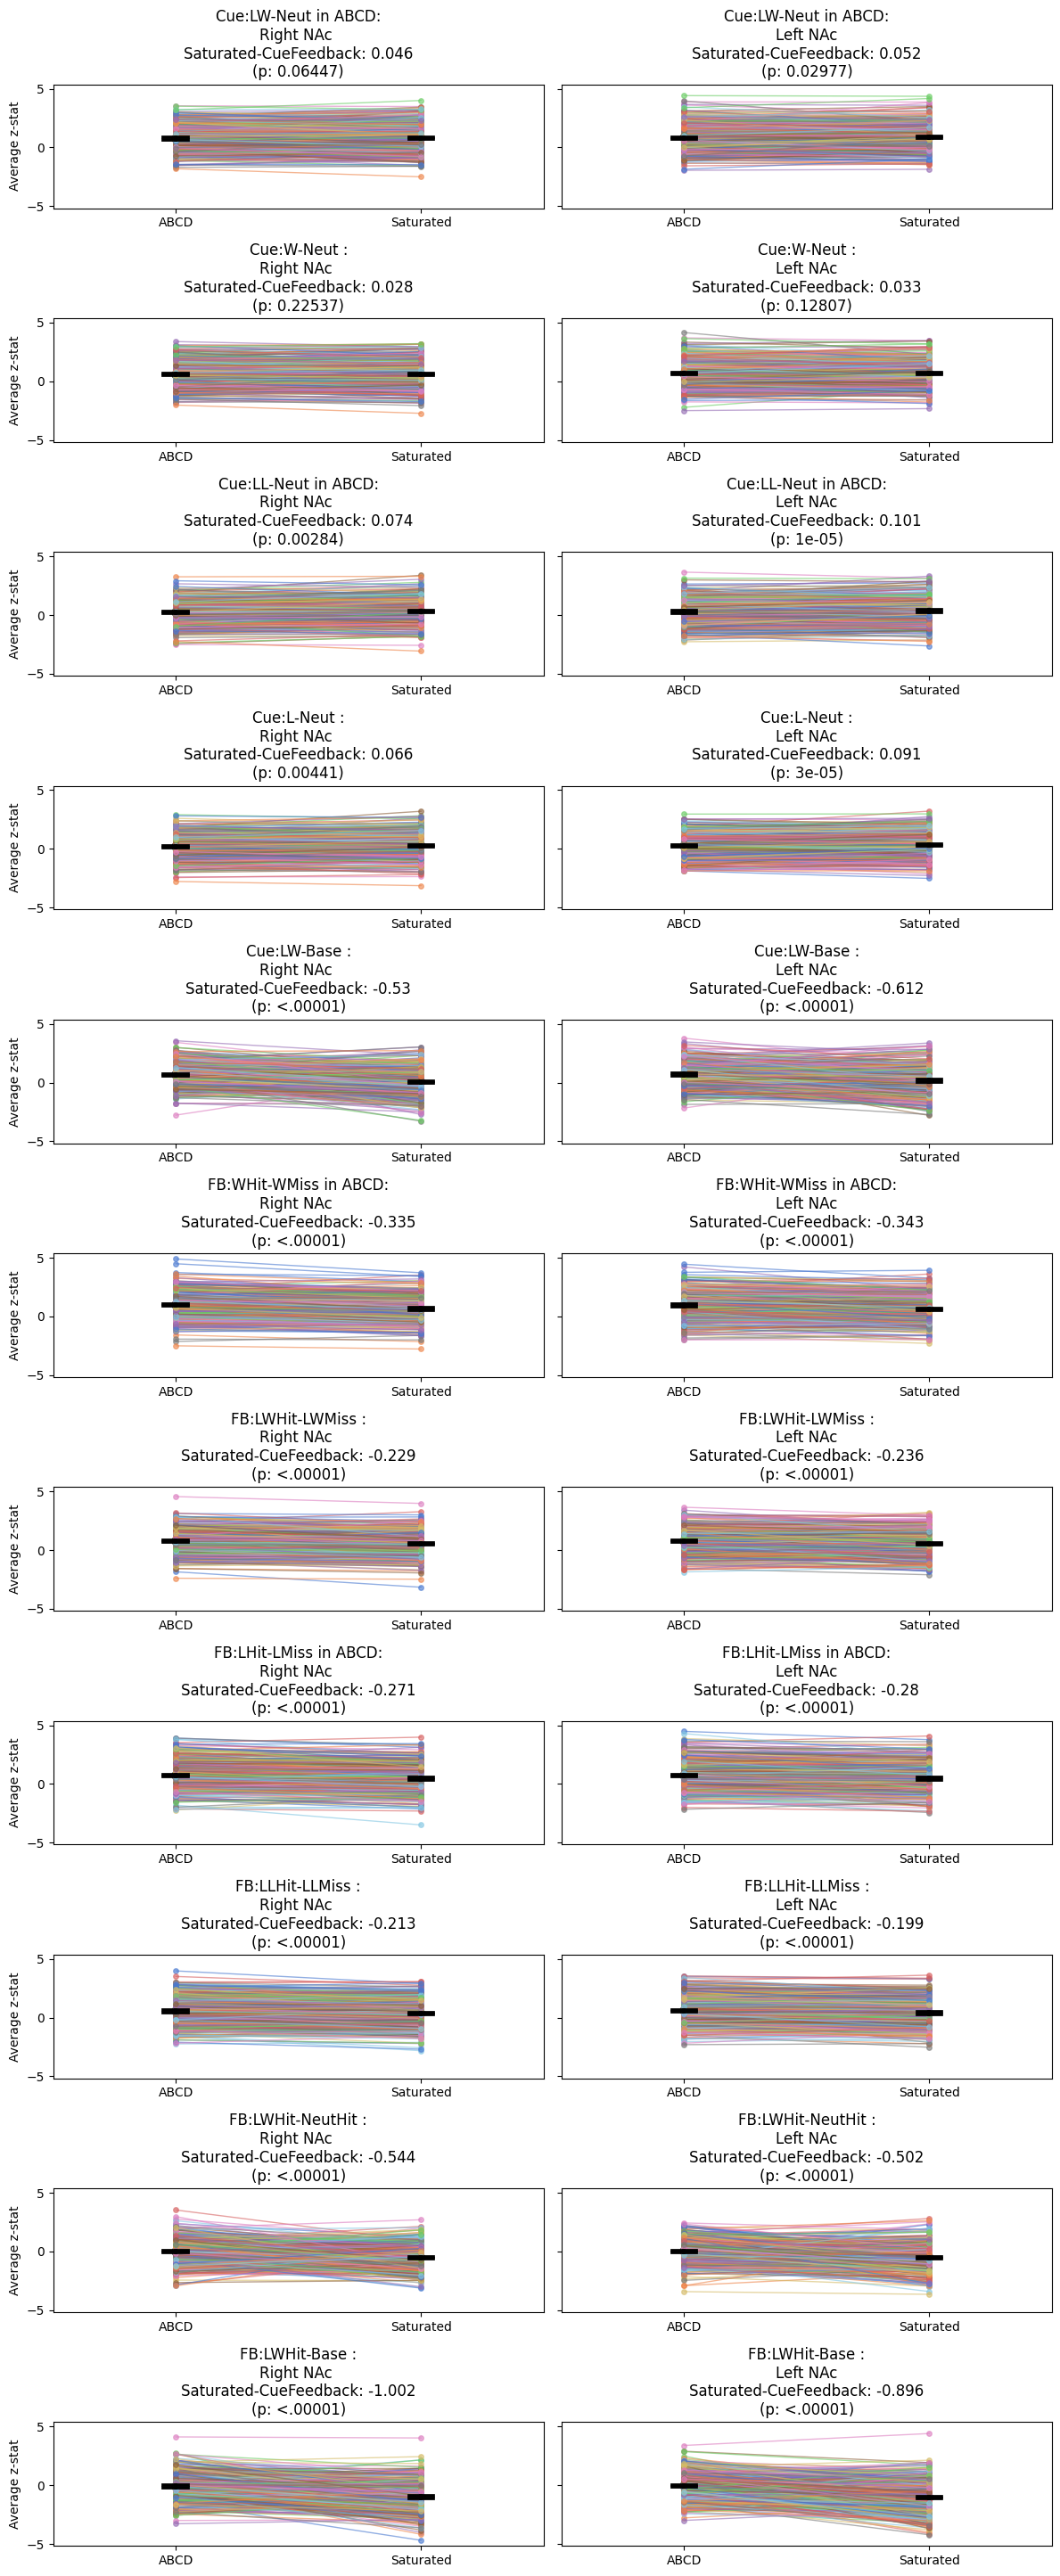

In [17]:
rows = len(contrasts_reg)
# side-by-side subplots
fig, axes = plt.subplots(rows, 2, figsize=(12, 29), sharey=True)

for i,con in enumerate(contrasts_reg):
    print("starting con:", con)
    
    if con in contrasts_inabcd.keys():
            in_abcd = contrasts_inabcd[con]
    else:
        in_abcd = ''
        
    abcd_img = f'{concat_imgs}/subs-500_ses-2YearFollowUpYArm1_task-MID_contrast-{con}_mod-CueYesDeriv.nii.gz'
    saturated_img = f'{concat_imgs}/subs-500_ses-2YearFollowUpYArm1_task-MID_contrast-{con}_mod-Saturated.nii.gz'
    
    abcd_data = image.load_img(abcd_img)
    saturated_data = image.load_img(saturated_img)
    
    # mask data roi
    abcd_left_data = masking.apply_mask(abcd_data, left_nac_img)
    abcd_right_data = masking.apply_mask(abcd_data, right_nac_img)
    
    saturated_left_data = masking.apply_mask(saturated_data, left_nac_img)
    saturated_right_data = masking.apply_mask(saturated_data, right_nac_img)
    
    # mean across voxels each subject /volume
    abcd_left_mean = abcd_left_data.mean(axis=1)
    abcd_right_mean = abcd_right_data.mean(axis=1)
    saturated_left_mean = saturated_left_data.mean(axis=1)
    saturated_right_mean = saturated_right_data.mean(axis=1)

    # Paired t-test & mean diff
    # modify p-value so not excessively large
    def format_pvalue(p):
        if p < 1e-5:
            return "<.00001"
        else:
            return round(p, 5)
    
    n_subjects = len(abcd_left_mean)
    
    # Prepare LEFT data
    data_left = pd.DataFrame({
    'Subject': [str(i) for i in range(n_subjects)],  # Convert to string
    'ABCD': abcd_left_mean,
    'Saturated': saturated_left_mean
    })

    
    data_left_long = pd.melt(
        data_left,
        id_vars=['Subject'],
        value_vars=['ABCD', 'Saturated'],
        var_name='Model',
        value_name='Zstat'
    )
    
    # Prepare RIGHT data
    data_right = pd.DataFrame({
        'Subject': [str(i) for i in range(n_subjects)],  # Convert to string
        'ABCD': abcd_right_mean,
        'Saturated': saturated_right_mean
    })
    
    data_right_long = pd.melt(
        data_right,
        id_vars=['Subject'],
        value_vars=['ABCD', 'Saturated'],
        var_name='Model',
        value_name='Zstat'
    )

    # left
    _, left_pval = stats.ttest_rel(data_left['Saturated'], data_left['ABCD'])
    left_pval = format_pvalue(left_pval)
    left_diff = round(np.mean(data_left['Saturated']) - np.mean(data_left['ABCD']),3)
    # right
    _, right_pval = stats.ttest_rel(data_right['Saturated'], data_right['ABCD'])
    right_pval = format_pvalue(right_pval)
    right_diff = round(np.mean(data_right['Saturated']) - np.mean(data_right['ABCD']),3)


    # LEFT plot - replace sns.lineplot with matplotlib
    colors = sns.color_palette("muted", n_subjects)

    for subject in range(n_subjects):
        axes[i,0].plot(['ABCD', 'Saturated'], 
                       [data_left.iloc[int(subject)]['ABCD'], data_left.iloc[int(subject)]['Saturated']], 
                       'o-', alpha=0.6, linewidth=1, color=colors[subject % len(colors)], markersize=4)
    sns.pointplot(
        data=data_left_long,
        x='Model',
        y='Zstat',
        color='black',
        join=False,
        markers='d',
        capsize=0.1,
        ax=axes[i,0]
    )
    axes[i,0].set_title(f'{con} {in_abcd}:\nRight NAc \nSaturated-CueFeedback: {right_diff}\n(p: {right_pval})')
    axes[i,0].set_ylabel('Average z-stat')
    axes[i,0].set_xlabel('')
    
    # RIGHT plot - replace sns.lineplot with matplotlib using seaborn colors
    for subject in range(n_subjects):
        axes[i,1].plot(['ABCD', 'Saturated'], 
                       [data_right.iloc[int(subject)]['ABCD'], data_right.iloc[int(subject)]['Saturated']], 
                       'o-', alpha=0.6, linewidth=1, color=colors[subject % len(colors)], markersize=4)
    sns.pointplot(
        data=data_right_long,
        x='Model',
        y='Zstat',
        color='black',
        join=False,
        markers='d',
        capsize=0.1,
        ax=axes[i,1]
    )
    axes[i,1].set_title(f'{con} {in_abcd}:\nLeft NAc\nSaturated-CueFeedback: {left_diff}\n(p: {left_pval})')
    axes[i,1].set_ylabel('')
    axes[i,1].set_xlabel('')
        
plt.tight_layout()
plt.savefig(f'{fig_out}/plot-paireddiff_nacc-zstats.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 4. Plotting Group maps

## 4.1 One sample t-test [Site adjusted - cluster corrected]: `mod-CueYesDeriv`c& `mod-Saturated`

#### 4.1.1 `Figure for Supplemental.` ABCD (CueYesDeriv), Saturated, and Diff: Saturated > ABCD  (11 contrasts)

/panfs/jay/groups/2/feczk001/mdemiden/analyses/mid_rt_bold/.venv/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


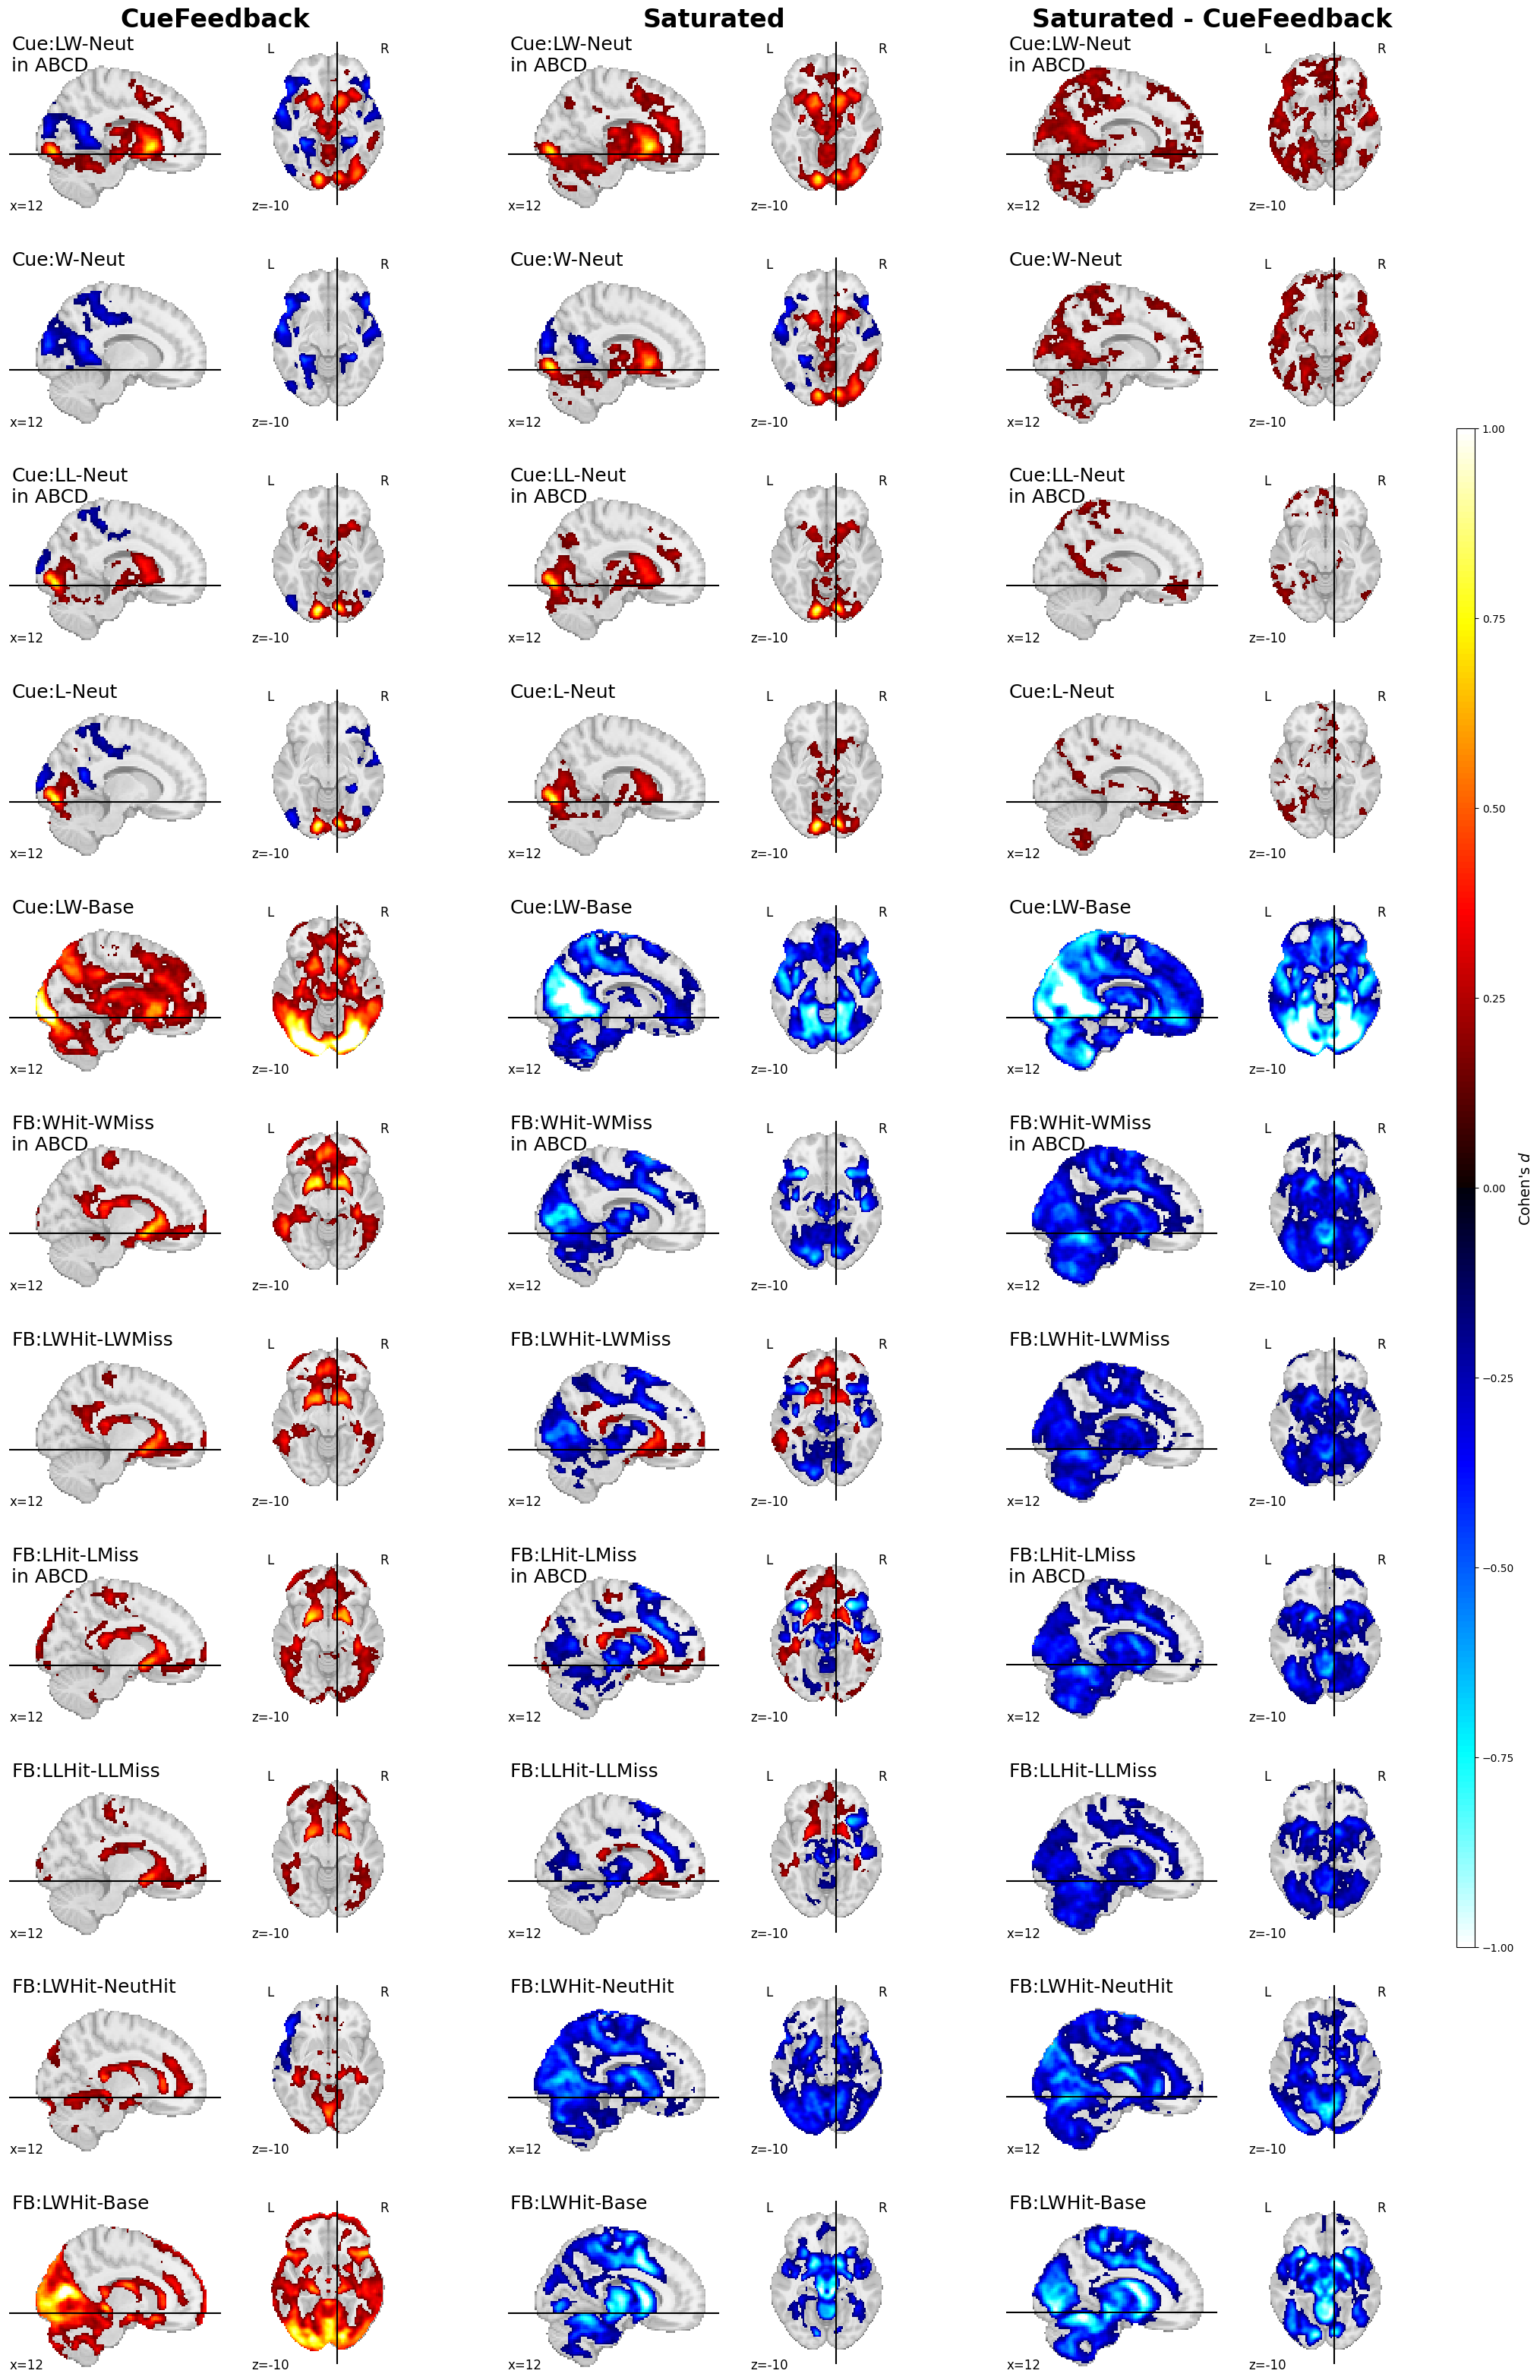

In [7]:
n_cols = len(sub_mods)
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(24,40)) # w x h

for col, mod in enumerate(sub_mods):
    model_name = custom_names[mod]
    axes[0, col].set_title(model_name, fontsize=24, weight='bold')  # column header
    
    for i, con in enumerate(contrasts_reg):
        in_abcd = contrasts_inabcd.get(con, '')
        show_colorbar = False
        formatted_title = f"{in_abcd} {con}"  # inside-plot caption title

        # Choose image path
        if mod != 'Diff: Saturated-CueYesDeriv':
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/subs-*_contrast-{con}_mod-{mod}_perm-cohensd.nii.gz')[0]
        else:
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/diff/subs-500_*_contrast-{con}_diff-Saturated-CueYesDeriv_perm-cohensd.nii.gz')[0]

        # Plot with nilearn, leave out matplotlib title
        display = plotting.plot_stat_map(stat_map_img=con_img,
                                         cut_coords=xz_cut_cords,
                                         display_mode="xz",
                                         title=None,
                                         draw_cross=True,
                                         vmax=1,
                                         colorbar=show_colorbar,
                                         axes=axes[i, col])

        # Set inside-plot caption title
        display.title(f"{con}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

# plot colorbar outside fig
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm)
cbar.set_label("Cohen's $d$", fontsize=14)


plt.savefig(f'{fig_out}/perm_mod-subset_cons-full_cohensd.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.1.2 Cue versus Fixation Componenets, `mod-Saturated` (d > .2)

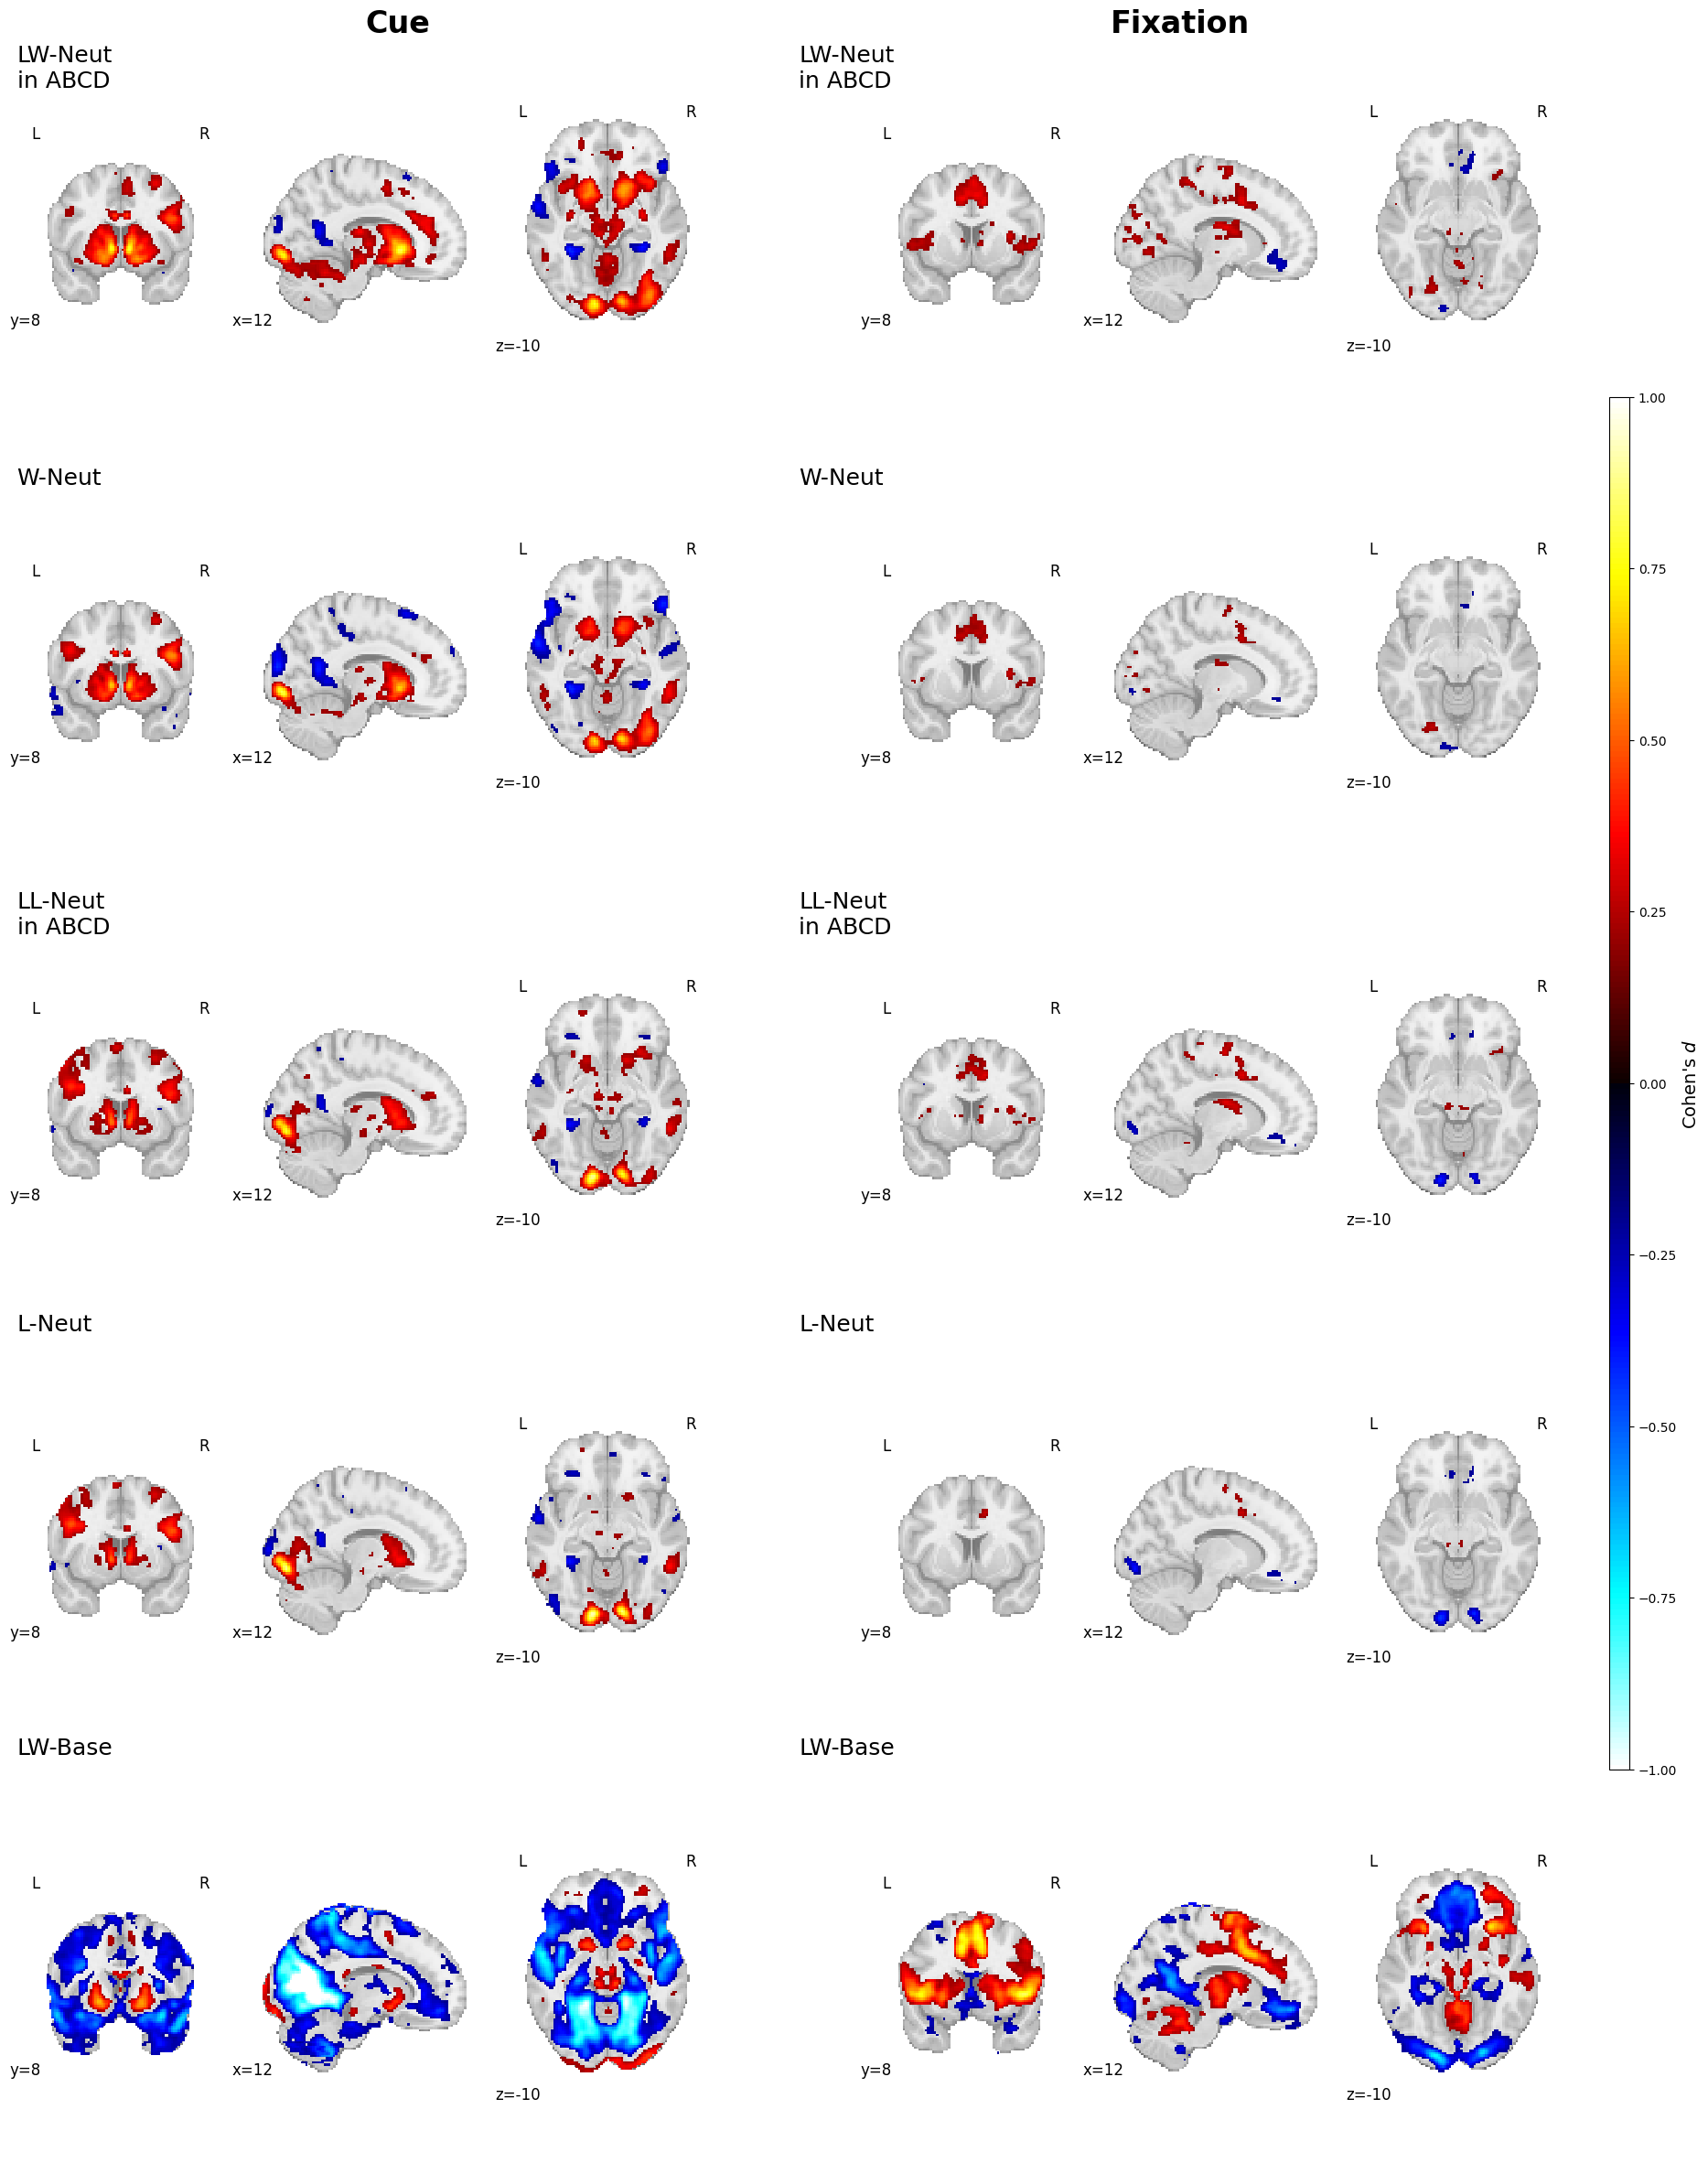

In [8]:
con_list = [# CUE
    'Cue:LW-Neut','Cue:W-Neut','Cue:LL-Neut','Cue:L-Neut', 'Cue:LW-Base',
    # FIX
    'Fix:LW-Neut','Fix:W-Neut','Fix:LL-Neut','Fix:L-Neut','Fix:LW-Base'
]

n_cols = 2
n_rows = len(con_list) // 2  # Only Cue and Fix, so half the list size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 30))
mod_single = 'Saturated'

# Set the general titles for the top of columns (before loop)
axes[0, 0].set_title("Cue", fontsize=24, weight='bold')
axes[0, 1].set_title("Fixation", fontsize=24, weight='bold')

for i, (cue_con, fix_con) in enumerate(zip(con_list[:n_rows], con_list[n_rows:])):
    in_abcd = contrasts_inabcd.get(cue_con, '')
        
    cue_con_img_pattern = f'{grpmap_path}/subs-*{cue_con}_mod-{mod_single}_stat-cohensd_int.nii.gz'
    fix_con_img_pattern = f'{grpmap_path}/subs-*{fix_con}_mod-{mod_single}_stat-cohensd_int.nii.gz'
    cue_con_img_files = glob(cue_con_img_pattern)
    fix_con_img_files = glob(fix_con_img_pattern)

    # Plot Cue contrast
    if cue_con_img_files:
        cue_con_img = cue_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=cue_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               threshold=d_thresh, draw_cross=False,
                               colorbar=False, vmax=1, 
                               axes=axes[i, 0])
        display.title(f"{cue_con.split(':')[1]}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

    # Plot Fixation contrast
    if fix_con_img_files:
        fix_con_img = fix_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=fix_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               threshold=d_thresh, draw_cross=False,
                               colorbar=False, vmax=1,
                               axes=axes[i, 1])  
        display.title(f"{fix_con.split(':')[1]}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)
        
# plot colorbar outside fig
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm)
cbar.set_label("Cohen's $d$", fontsize=14)

plt.subplots_adjust(hspace=0.005, wspace=0.005)
plt.show()

#### 4.1.3 `Figure for supplemental.` Site-adjusted Permutation for Cue & Fix Components 

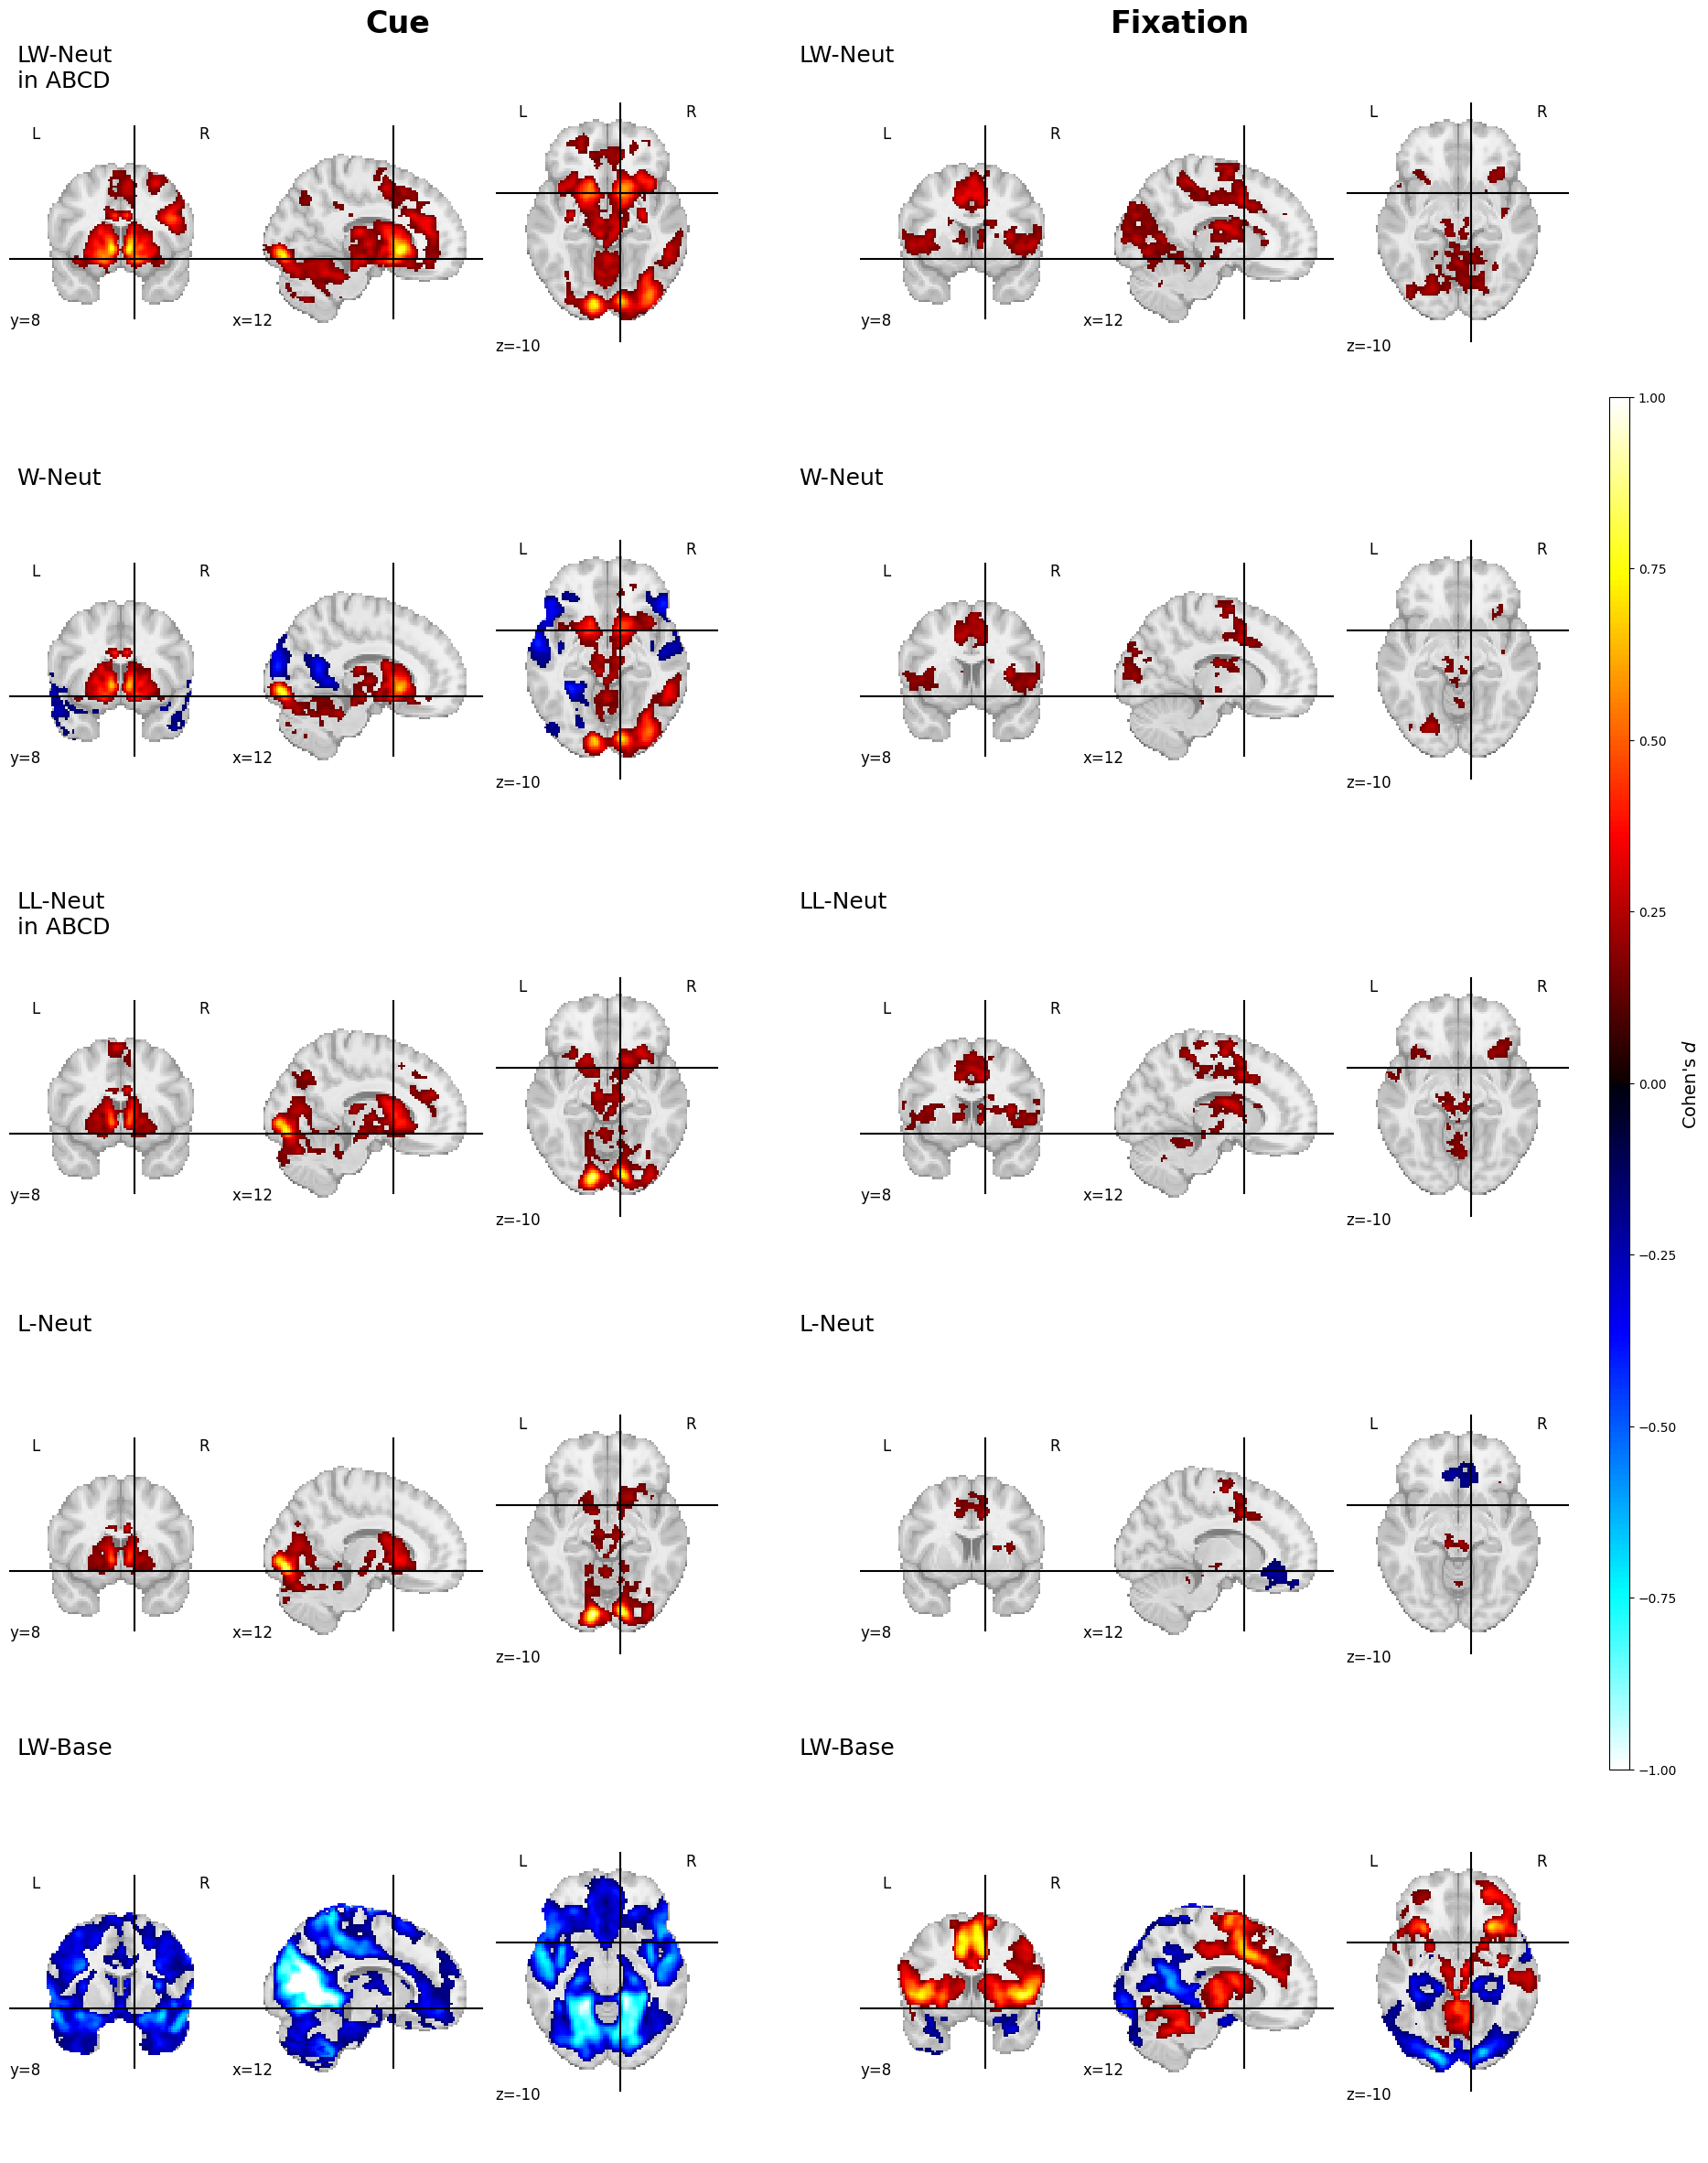

In [9]:
con_list = [# CUE
    'Cue:LW-Neut','Cue:W-Neut','Cue:LL-Neut','Cue:L-Neut', 'Cue:LW-Base',
    # FIX
    'Fix:LW-Neut','Fix:W-Neut','Fix:LL-Neut','Fix:L-Neut','Fix:LW-Base'
]

n_cols = 2
n_rows = len(con_list) // 2  # Only Cue and Fix, so half the list size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 30))
mod_single = 'Saturated'

# Set the general titles for the top of columns (before loop)
axes[0, 0].set_title("Cue", fontsize=24, weight='bold')
axes[0, 1].set_title("Fixation", fontsize=24, weight='bold')

for i, (cue_con, fix_con) in enumerate(zip(con_list[:n_rows], con_list[n_rows:])):
    in_abcd = contrasts_inabcd.get(cue_con, '')
        
    cue_con_img_pattern = f'{grpmap_path}/custom/outmaps/{cue_con}/subs-*_contrast-{cue_con}_mod-{mod_single}_perm-cohensd.nii.gz'
    fix_con_img_pattern = f'{grpmap_path}/custom/outmaps/{fix_con}/subs-*_contrast-{fix_con}_mod-{mod_single}_perm-cohensd.nii.gz'
    cue_con_img_files = glob(cue_con_img_pattern)
    fix_con_img_files = glob(fix_con_img_pattern)

    # Plot Cue contrast
    if cue_con_img_files:
        cue_con_img = cue_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=cue_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               draw_cross=True,
                               colorbar=False, vmax=1, 
                               axes=axes[i, 0])
        display.title(f"{cue_con.split(':')[1]}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

    # Plot Fixation contrast
    if fix_con_img_files:
        fix_con_img = fix_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=fix_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho", draw_cross=True,
                               colorbar=False, vmax=1,
                               axes=axes[i, 1])  
        display.title(f"{fix_con.split(':')[1]}", size=18, color='black', bgcolor='white', alpha=1)
        
# plot colorbar outside fig
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm)
cbar.set_label("Cohen's $d$", fontsize=14)

plt.subplots_adjust(hspace=0.005, wspace=0.005)
plt.savefig(f'{fig_out}/perm_mod-grpconmaps_componenet-cuevfix_cohensd.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.1.4 One sample t-tests (permuted, site-adjusted) Subset Contrasts: `mod-CueYesDeriv` & `mod-Saturated`

#### `Figure for Paper.` ABCD (CueYesDeriv), Saturated, and Diff: Saturated > ABCD (7 contrasts)

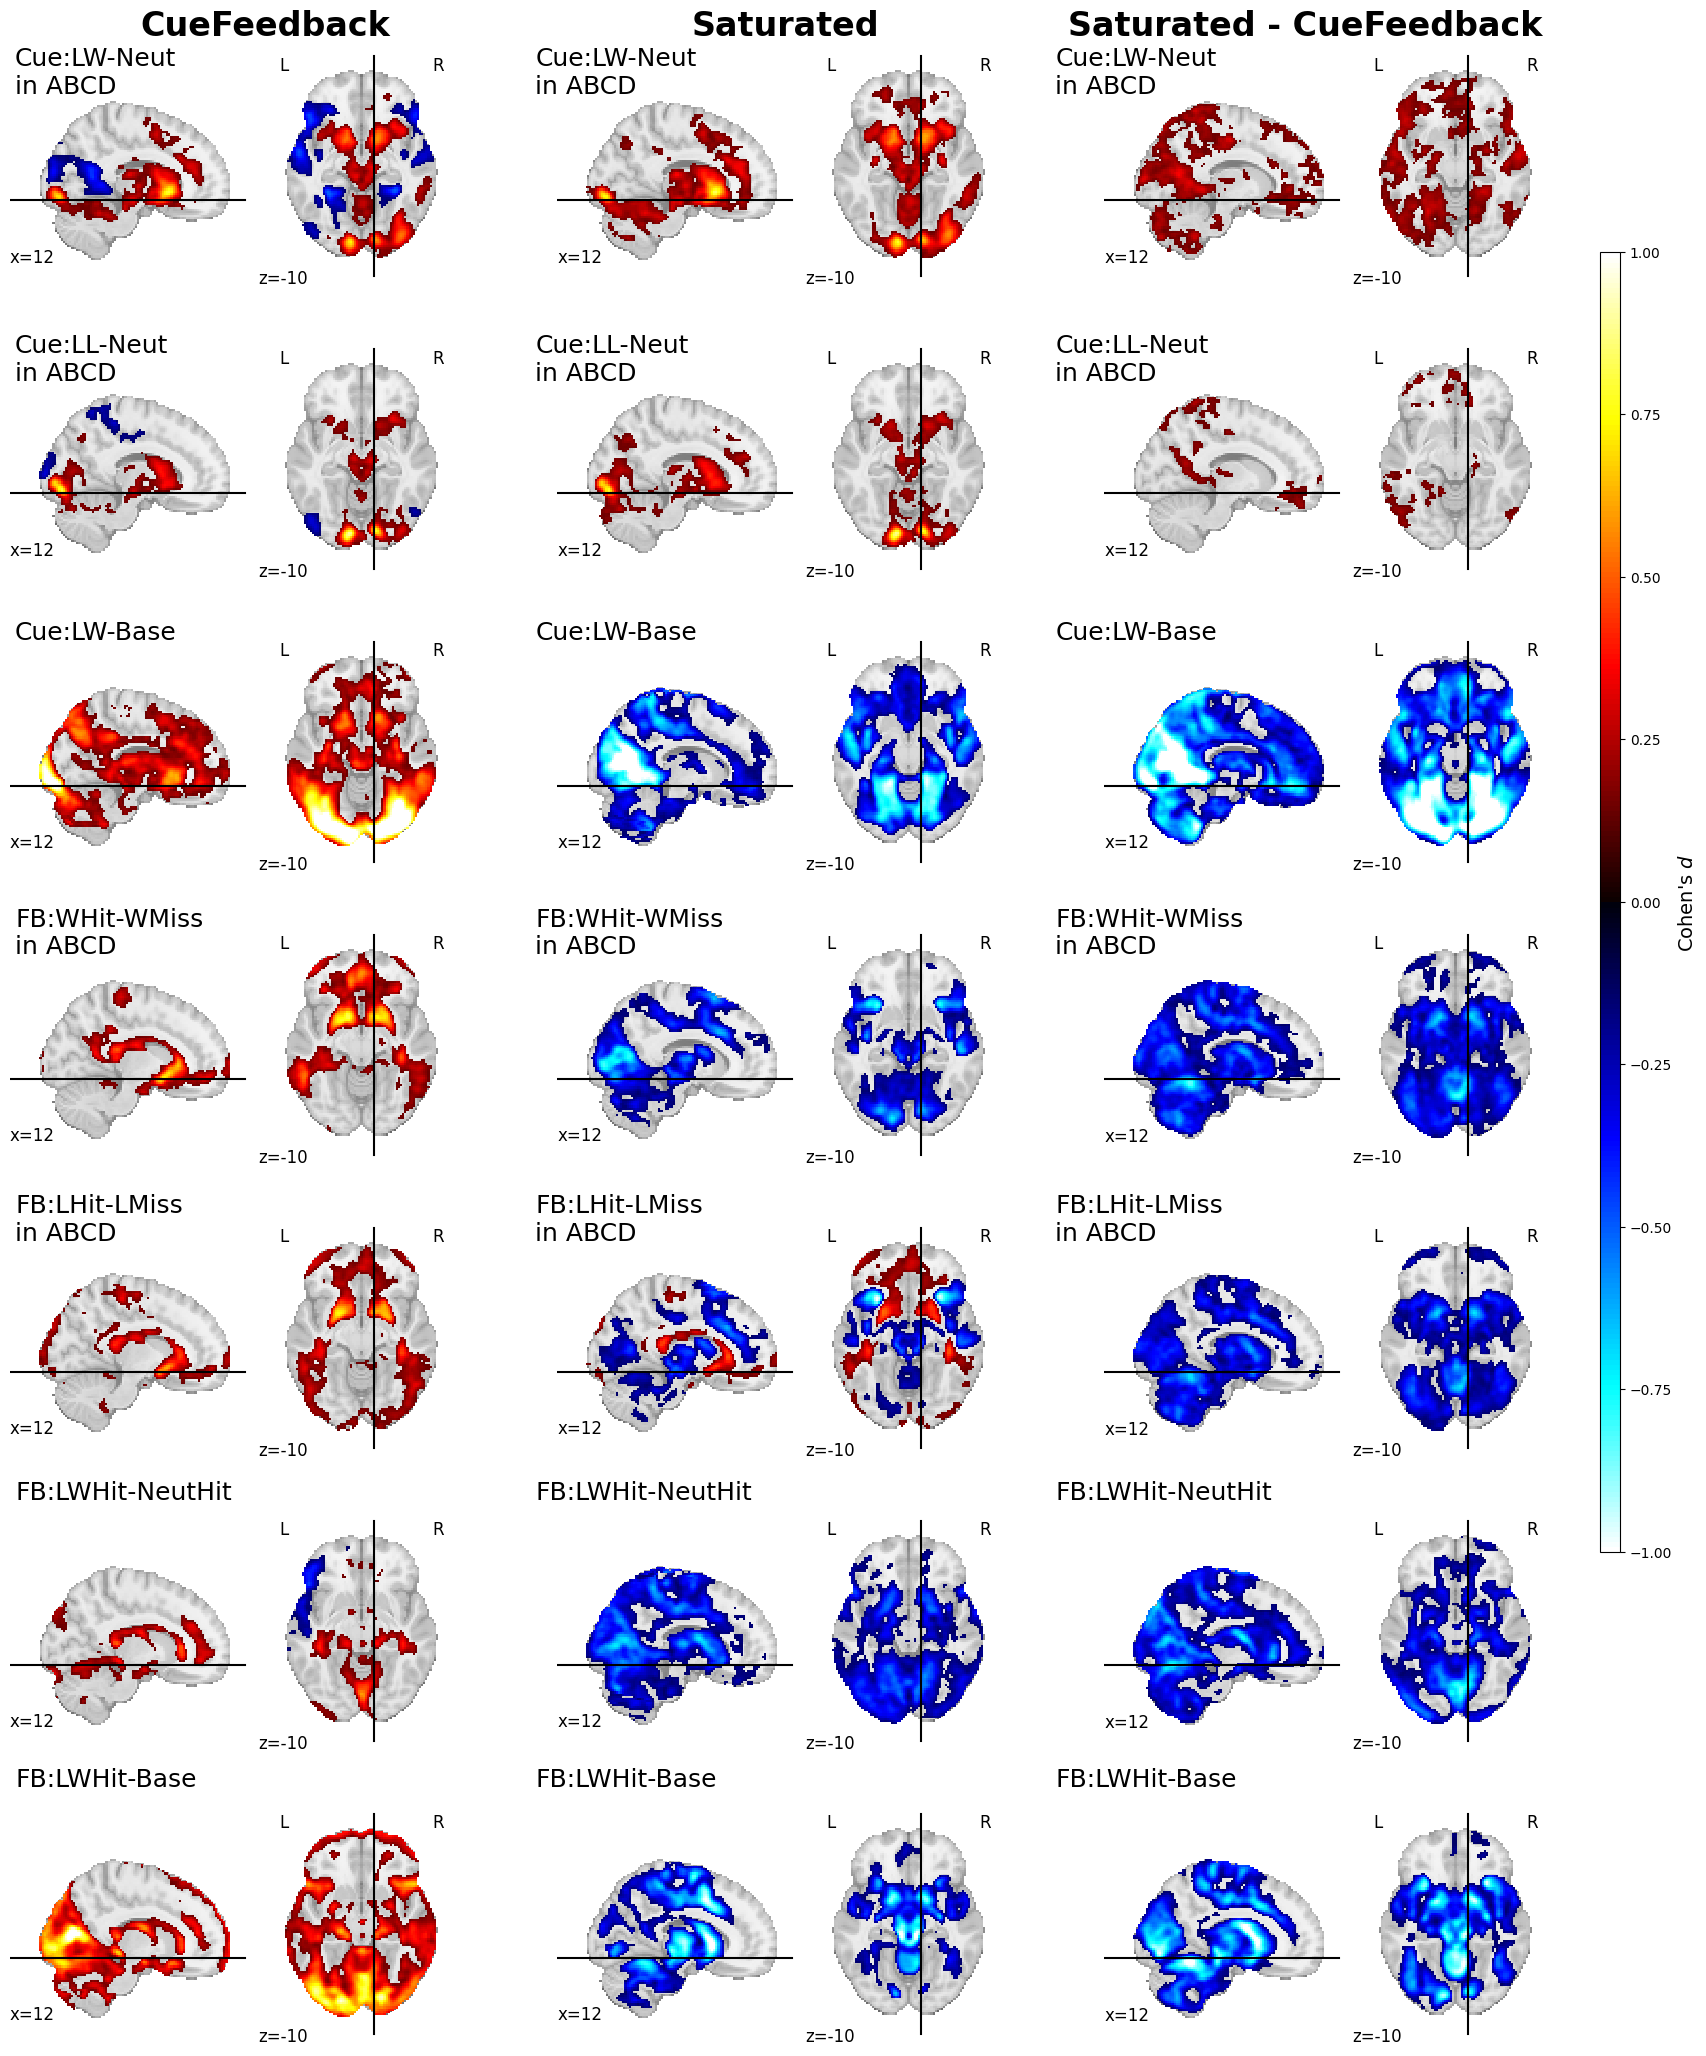

In [10]:
n_cols = len(sub_mods)
n_rows = len(sub_cons)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 26))  # width x height

# Loop over subplots
for col, mod in enumerate(sub_mods):
    model_name = custom_names[mod]
    axes[0, col].set_title(model_name, fontsize=24, weight='bold')
    
    for i, con in enumerate(sub_cons):
        in_abcd = contrasts_inabcd.get(con, '')
        
        show_colorbar = False #(col == n_cols - 1)  # only show color bar for last col

        if mod != 'Diff: Saturated-CueYesDeriv':
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/subs-*_contrast-{con}_mod-{mod}_perm-cohensd.nii.gz')[0]
        else:
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/diff/subs-500_*_contrast-{con}_diff-Saturated-CueYesDeriv_perm-cohensd.nii.gz')[0]
 

        # Plot with nilearn, leave out matplotlib title
        display = plotting.plot_stat_map(stat_map_img=con_img,
                                         cut_coords=xz_cut_cords,
                                         display_mode="xz",
                                         title=None,
                                         draw_cross=True,
                                         vmax=1,
                                         colorbar=show_colorbar,
                                         axes=axes[i, col])

        # Set inside-plot caption title
        display.title(f"{con}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

# colorbar separately outside of figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm) 
cbar.set_label("Cohen's $d$", fontsize=14)

plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust spacing
plt.savefig(f'{fig_out}/perm_mod-subsetmaps_cohensd_ex.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.2 Additional contrast estimates

### 4.2.2 Paired T-test Diff (site-adjusted, corrected), `Saturated - CueYesDeriv`

The `4.2.1` takes the order of operations: estimates a group average maps for each contrast (TFCE, permutations = 1000) for the Saturated & CueYesDeriv  models (e.g., RT & DAIRC model), and then takes the difference for the TFCE p < .05 voxels in the Cohen's d maps. 

The below takes the difference at the run avg map for each subject. Specifically, the difference between the Saturated & CueYesDeriv  models for the effect maps from the weighted fixed effects. Then, this difference map is used in randomise (TFCE, permutations = 1000) to estimate the voxels that are significantly different from the [Saturated - CueYesDeriv] fixed effect estimates. The significant voxels (TFCE < .05) are then plotted for the Cohen's d map.

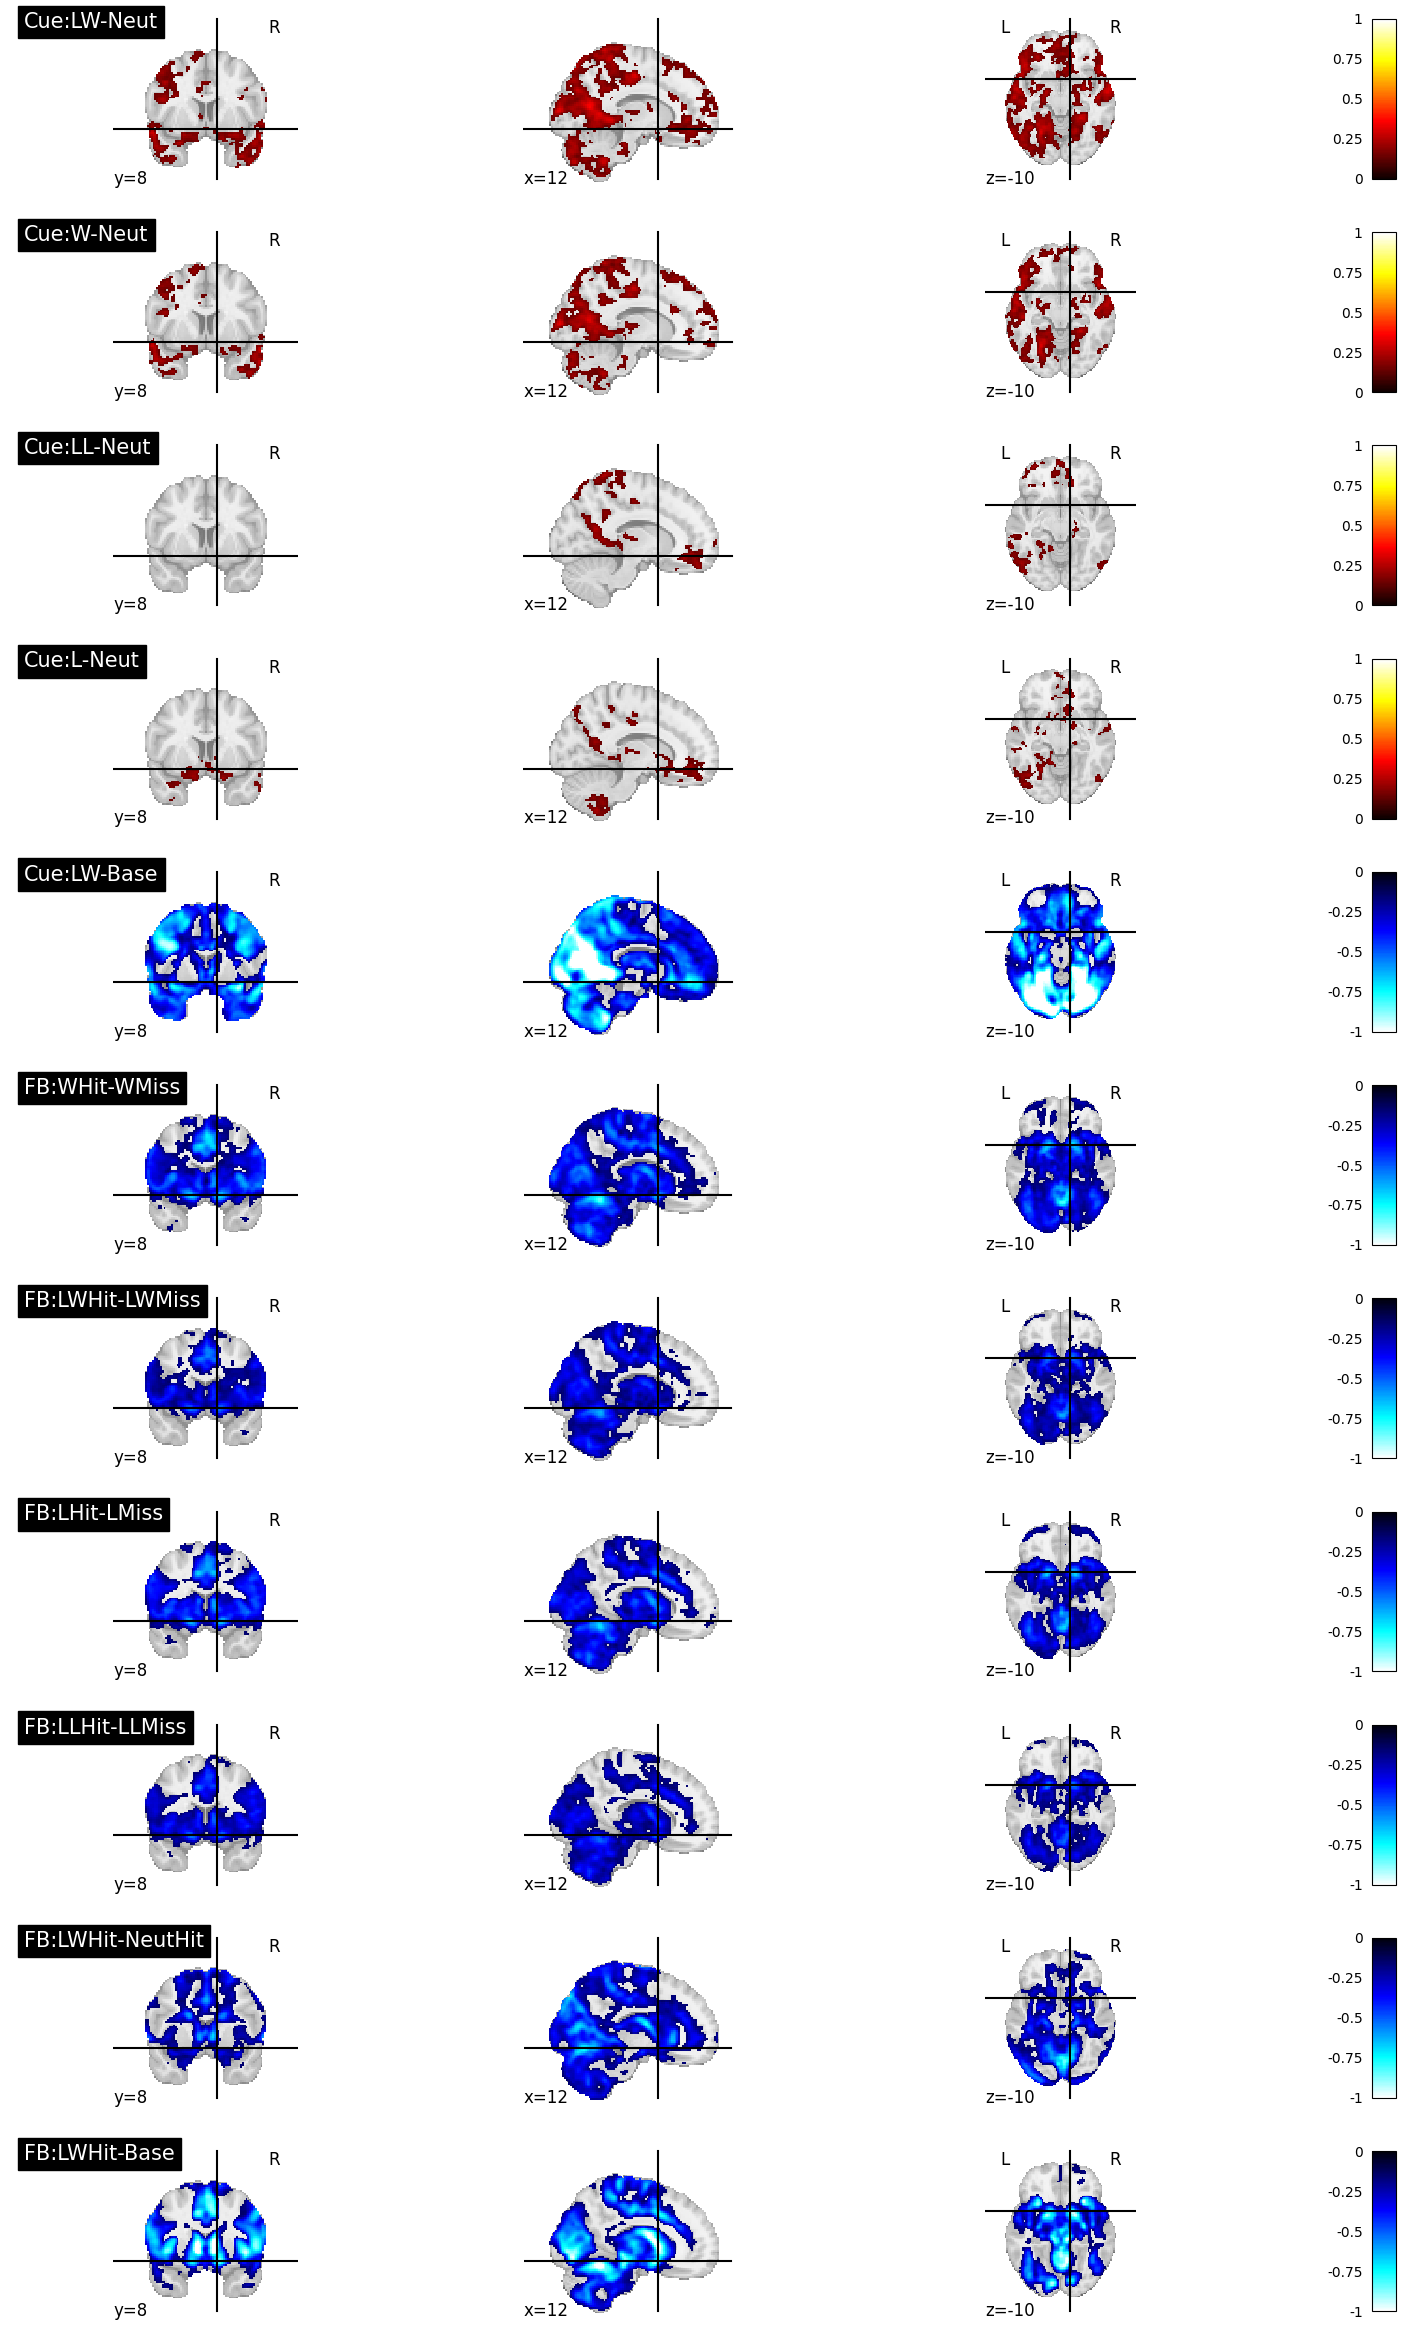

In [13]:
fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, con in enumerate(contrasts_reg):
    con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/diff/subs-500_*_contrast-{con}_diff-Saturated-CueYesDeriv_perm-cohensd.nii.gz')[0]
    plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                           display_mode="ortho", vmax=1,
                           title=f"{con}",  
                           draw_cross=True,colorbar=True,
                           axes=axes[i])

## 4.2.2 One sample t-test [Site adjusted - UNCORRECTED]

`Supplemental uncorrected map: Model Differences`

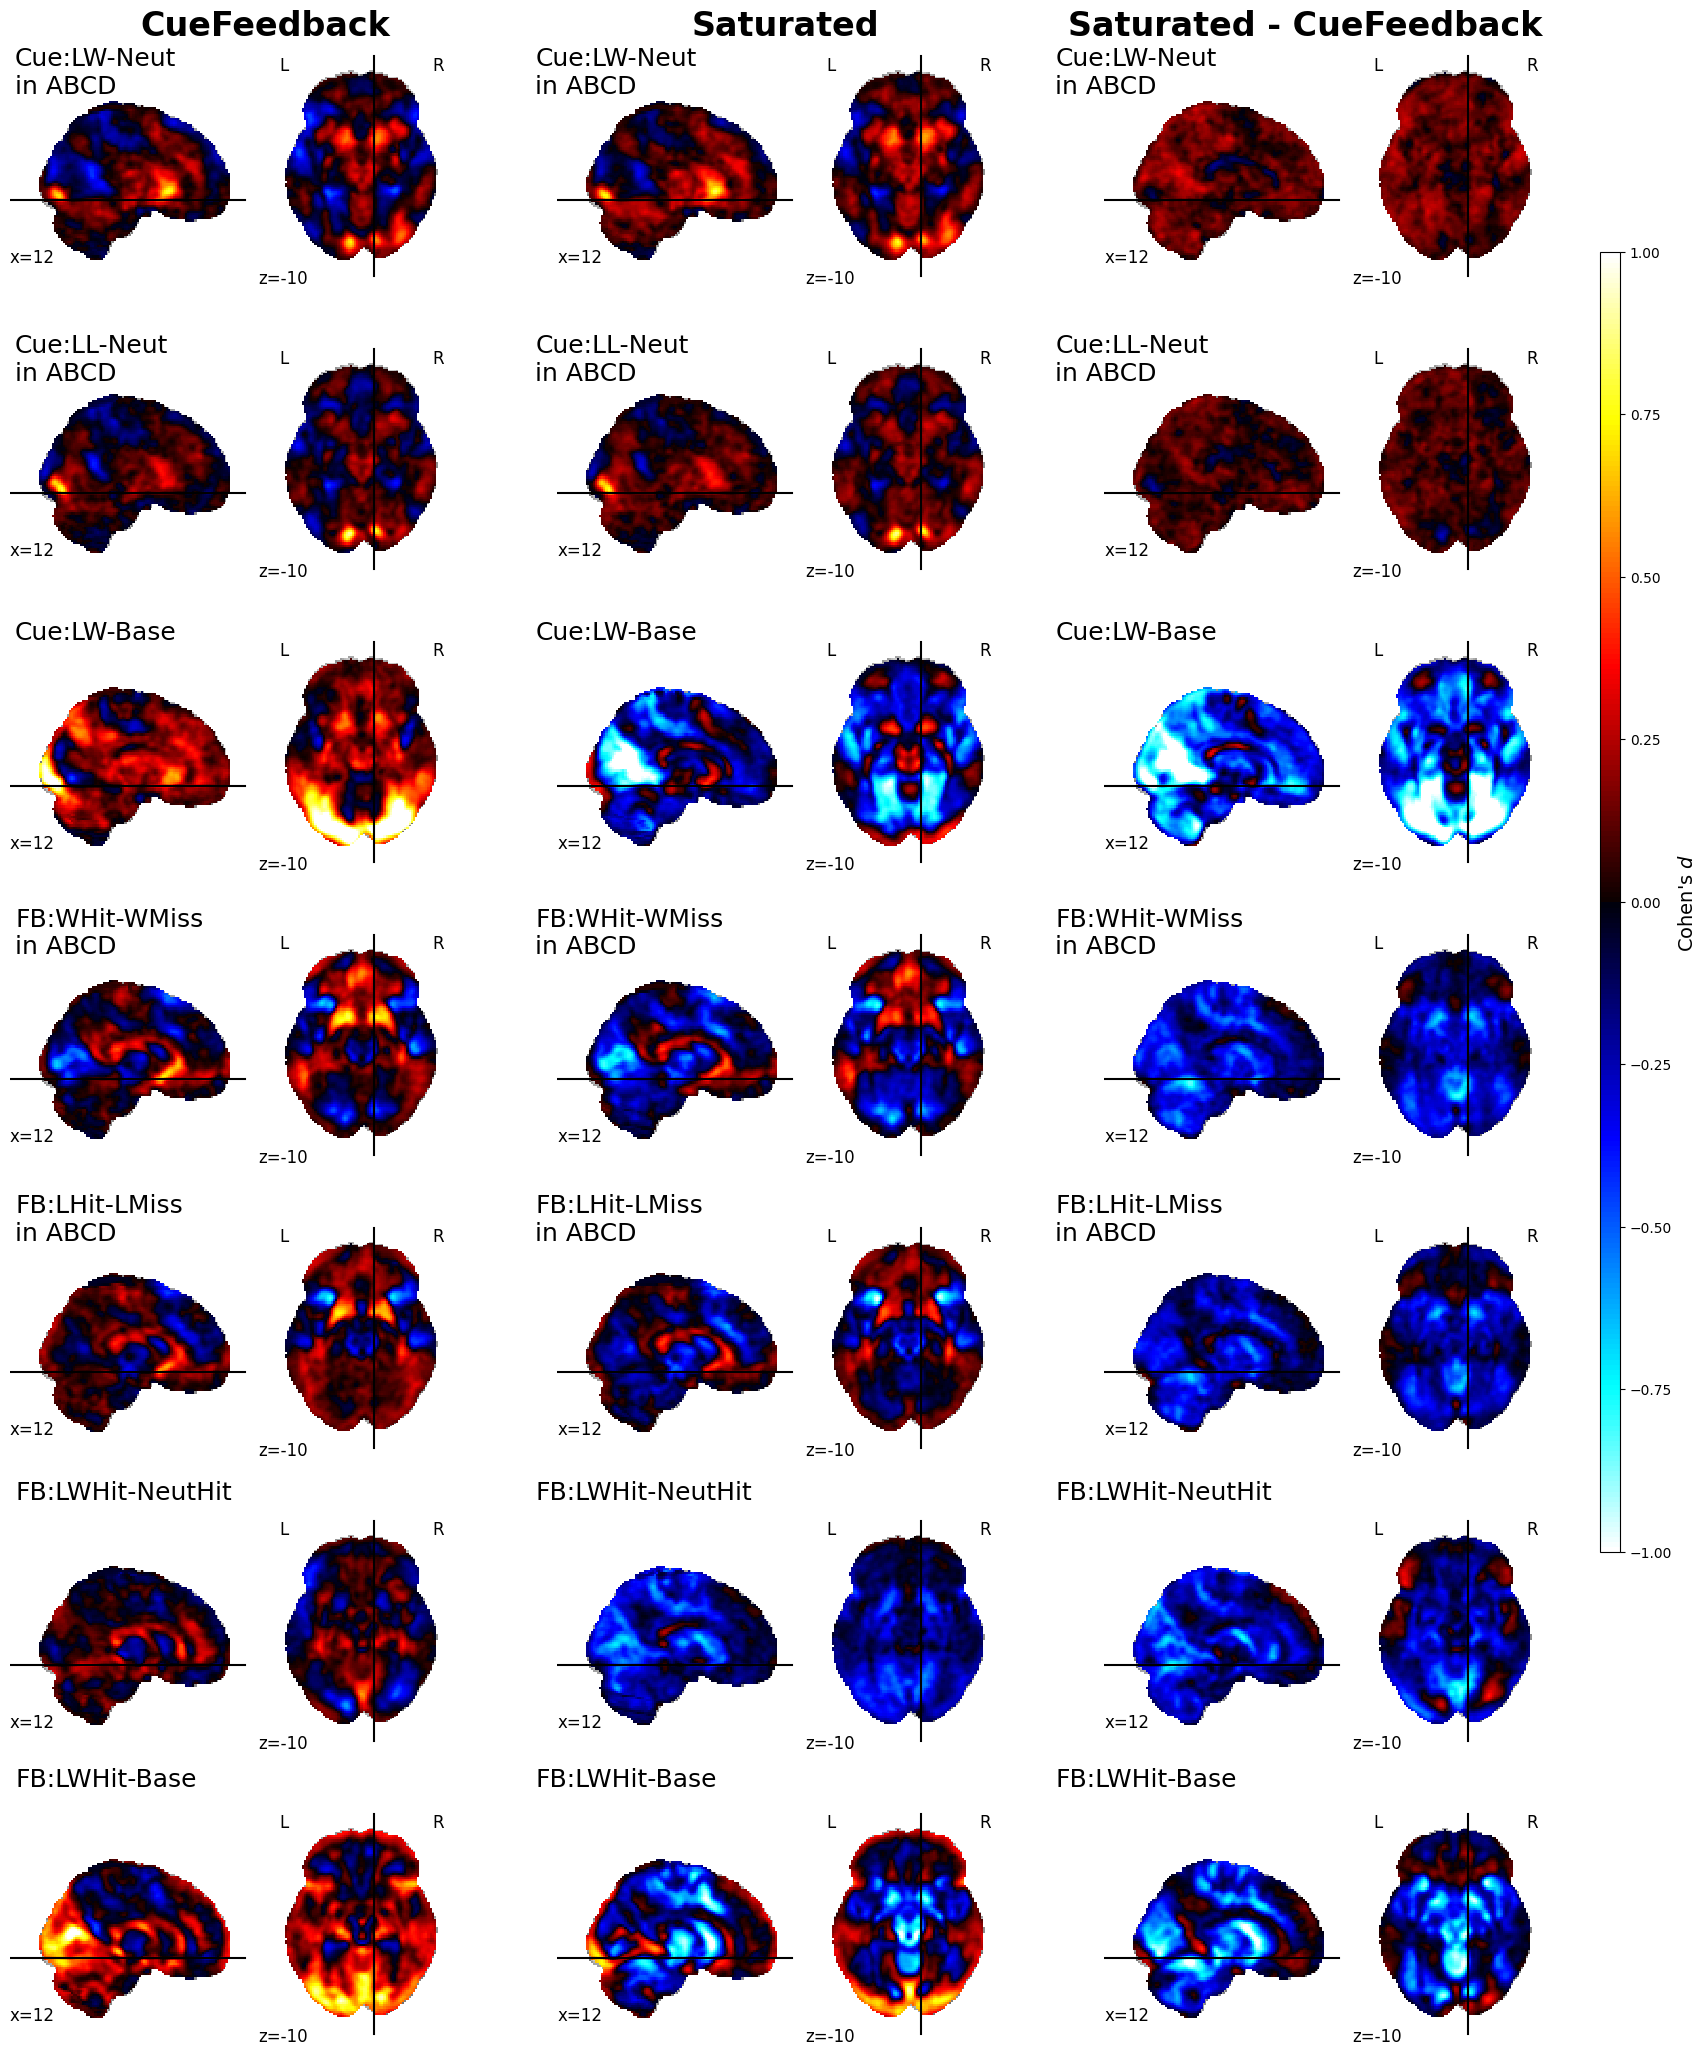

In [14]:
n_cols = len(sub_mods)
n_rows = len(sub_cons)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 26))  # width x height

# Loop over subplots
for col, mod in enumerate(sub_mods):
    model_name = custom_names[mod]
    axes[0, col].set_title(model_name, fontsize=24, weight='bold')
    
    for i, con in enumerate(sub_cons):
        in_abcd = contrasts_inabcd.get(con, '')
            
        show_colorbar = False #(col == n_cols - 1)  # only show color bar for last col

        if mod != 'Diff: Saturated-CueYesDeriv':
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/subs-*_contrast-{con}_mod-{mod}_perm-cohensd-uncorr.nii')[0]
        else:
            con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/diff/subs-500_*_contrast-{con}_diff-Saturated-CueYesDeriv_perm-cohensd-uncorr.nii.gz')[0]

                # Plot with nilearn, leave out matplotlib title
        display = plotting.plot_stat_map(stat_map_img=con_img,
                                         cut_coords=xz_cut_cords,
                                         display_mode="xz",
                                         title=None,
                                         draw_cross=True,
                                         vmax=1,
                                         colorbar=show_colorbar,
                                         axes=axes[i, col])

        # Set inside-plot caption title
        display.title(f"{con}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

# colorbar separately outside of figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm) 
cbar.set_label("Cohen's $d$", fontsize=14)

plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust spacing
plt.savefig(f'{fig_out}/perm_mod-subsetmaps_cohensd-uncorr.pdf', format='pdf', bbox_inches='tight')
plt.show()

`Supplemental uncorrected map: cue & fix`

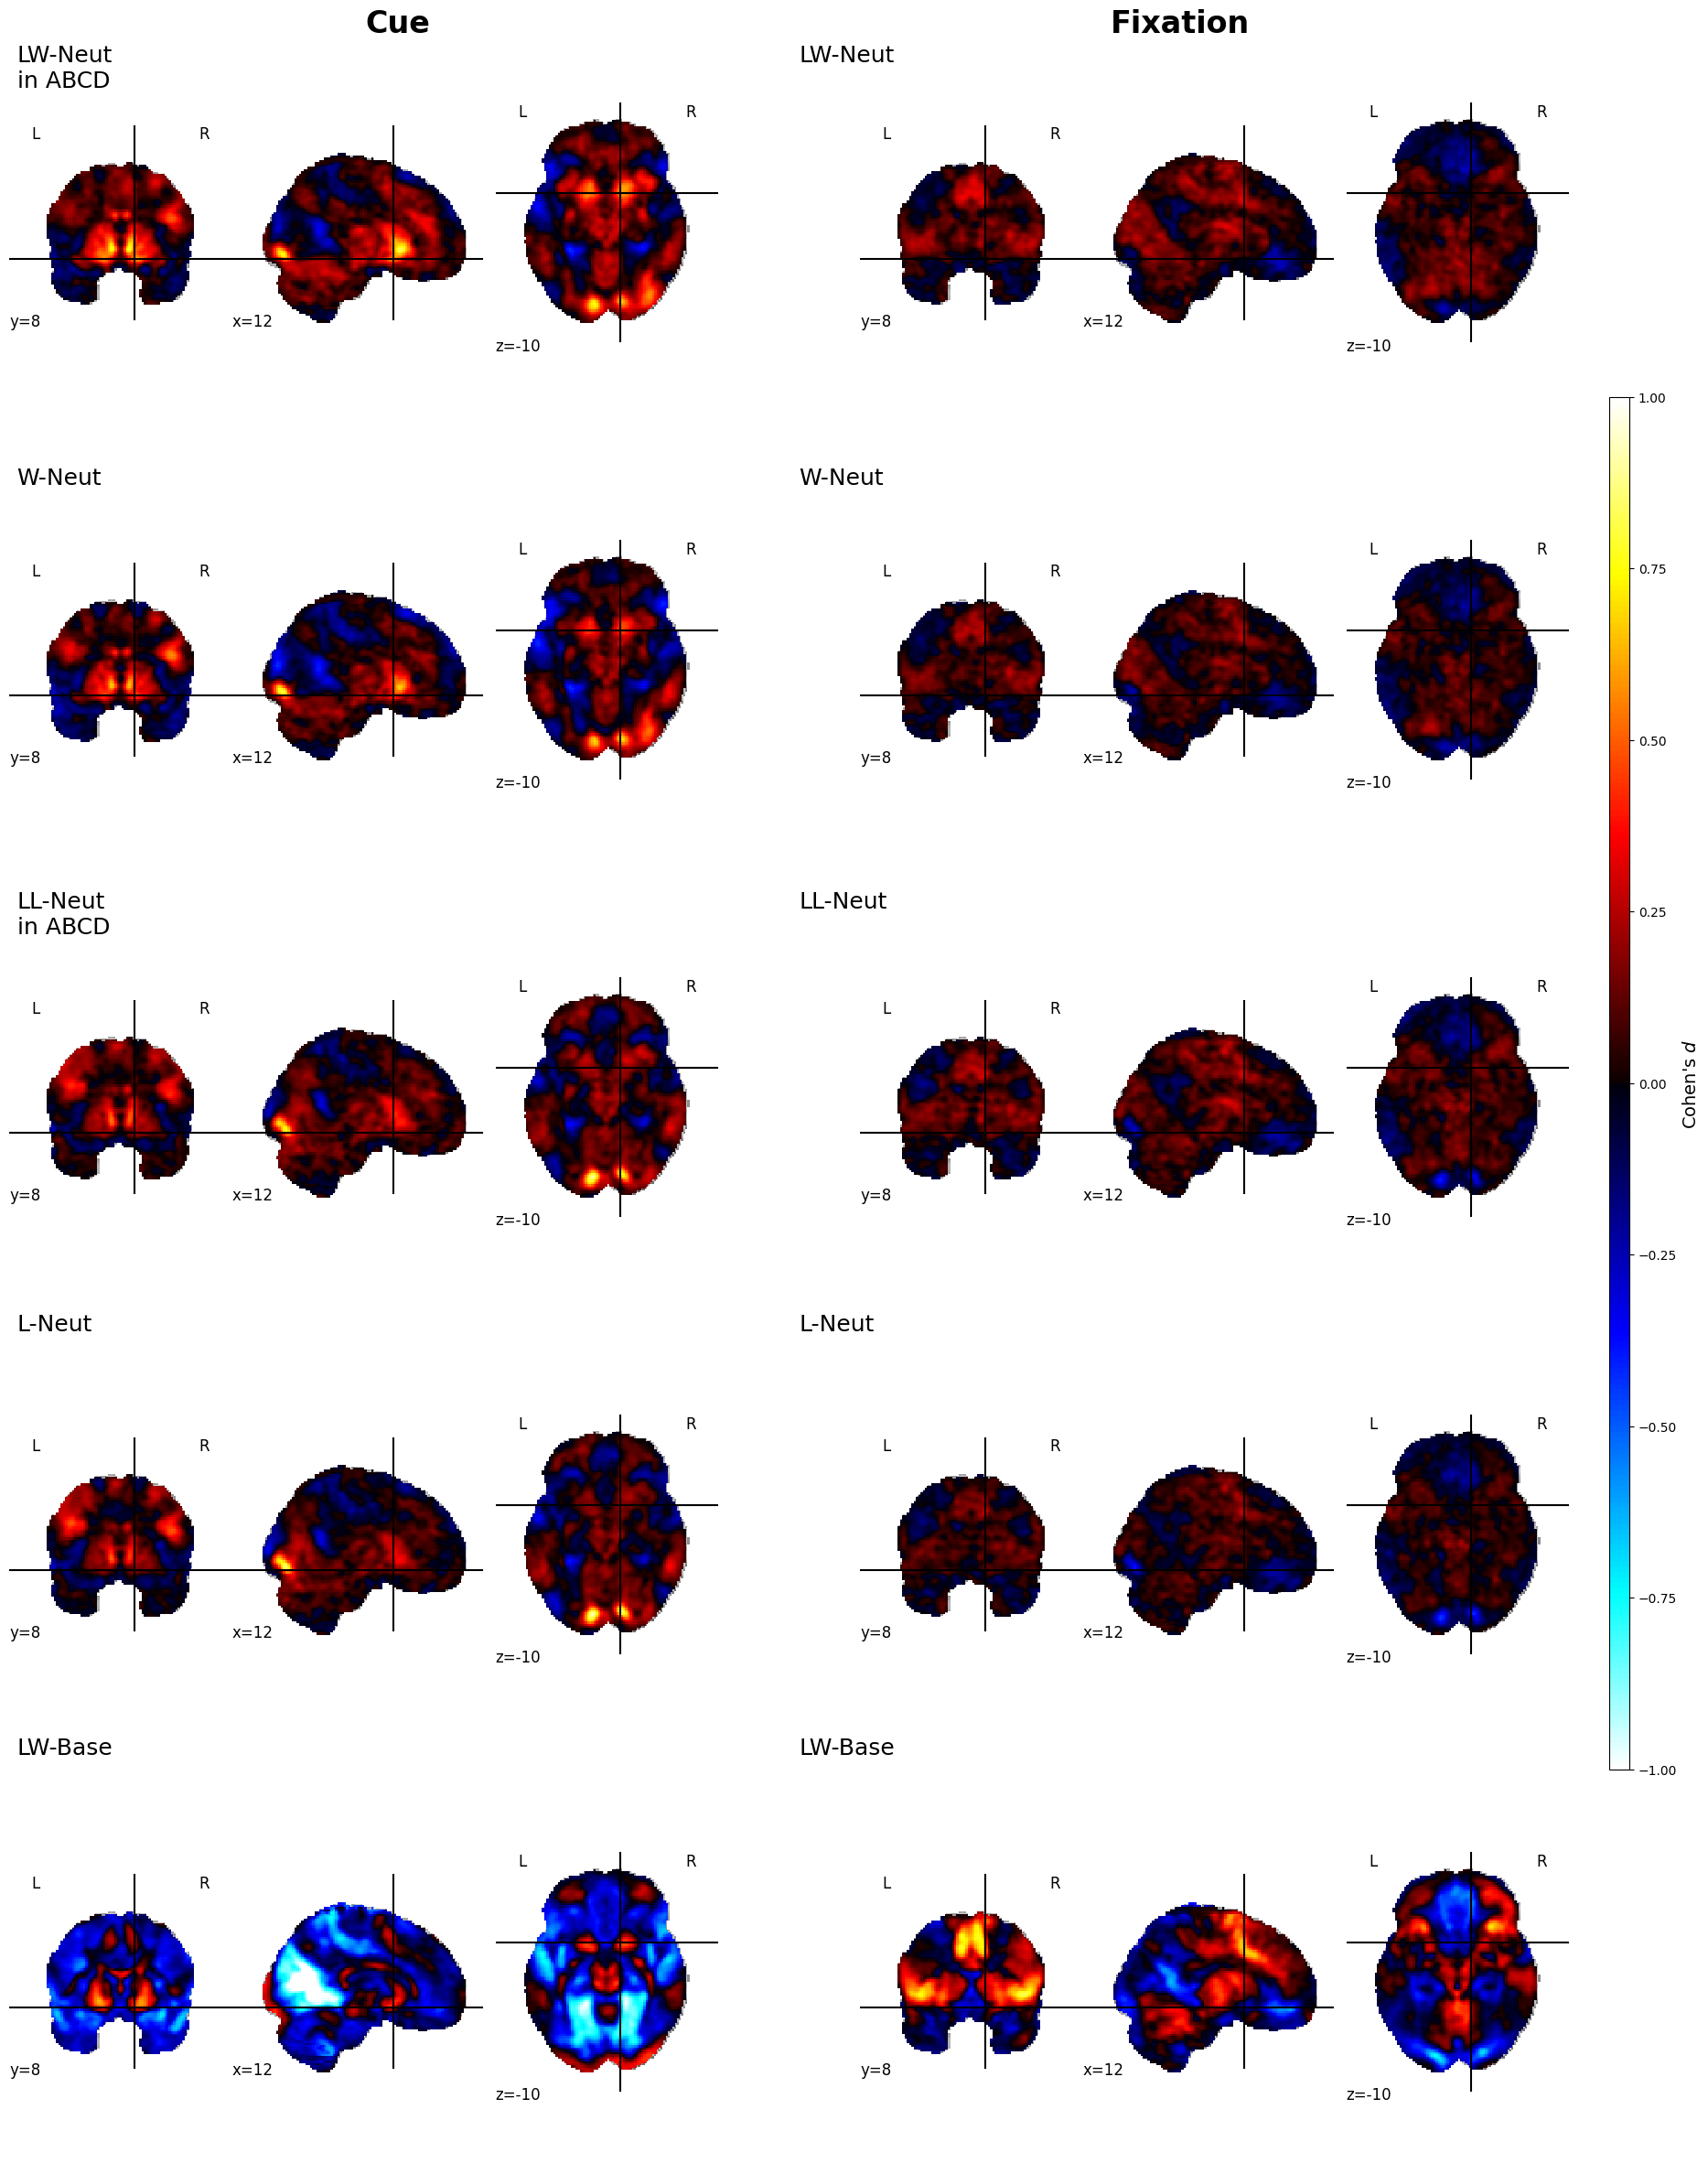

In [15]:
con_list = [# CUE
    'Cue:LW-Neut','Cue:W-Neut','Cue:LL-Neut','Cue:L-Neut', 'Cue:LW-Base',
    # FIX
    'Fix:LW-Neut','Fix:W-Neut','Fix:LL-Neut','Fix:L-Neut','Fix:LW-Base'
]

n_cols = 2
n_rows = len(con_list) // 2  # Only Cue and Fix, so half the list size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 30))
mod_single = 'Saturated'

# Set the general titles for the top of columns (before loop)
axes[0, 0].set_title("Cue", fontsize=24, weight='bold')
axes[0, 1].set_title("Fixation", fontsize=24, weight='bold')

for i, (cue_con, fix_con) in enumerate(zip(con_list[:n_rows], con_list[n_rows:])):
    in_abcd = contrasts_inabcd.get(cue_con, '')
        
    cue_con_img_pattern = f'{grpmap_path}/custom/outmaps/{cue_con}/subs-*_contrast-{cue_con}_mod-{mod_single}_perm-cohensd-uncorr.nii'
    fix_con_img_pattern = f'{grpmap_path}/custom/outmaps/{fix_con}/subs-*_contrast-{fix_con}_mod-{mod_single}_perm-cohensd-uncorr.nii'
    cue_con_img_files = glob(cue_con_img_pattern)
    fix_con_img_files = glob(fix_con_img_pattern)

    # Plot Cue contrast
    if cue_con_img_files:
        cue_con_img = cue_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=cue_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               draw_cross=True,
                               colorbar=False, vmax=1, 
                               axes=axes[i, 0])
        display.title(f"{cue_con.split(':')[1]}\n{in_abcd}", size=18, color='black', bgcolor='white', alpha=0)

    # Plot Fixation contrast
    if fix_con_img_files:
        fix_con_img = fix_con_img_files[0]
        display = plotting.plot_stat_map(stat_map_img=fix_con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho", draw_cross=True,
                               colorbar=False, vmax=1,
                               axes=axes[i, 1])  
        display.title(f"{fix_con.split(':')[1]}", size=18, color='black', bgcolor='white', alpha=1)
        
# plot colorbar outside fig
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # adjust x, y, width, height
norm = plt.Normalize(vmin=-1, vmax=1)  # Adjust based on your data range
cbar = mpl_colorbar.ColorbarBase(cbar_ax, cmap=plt.get_cmap('cold_hot'), norm=norm)
cbar.set_label("Cohen's $d$", fontsize=14)

plt.subplots_adjust(hspace=0.005, wspace=0.005)
plt.savefig(f'{fig_out}/perm_mod-grpconmaps_componenet-cuevfix_cohensd-uncorr.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 4.3 Avgerage RT/Probe, Site-adjusted permutation

#### `Figure for Supplemental.` Probe & RT Avg Effect

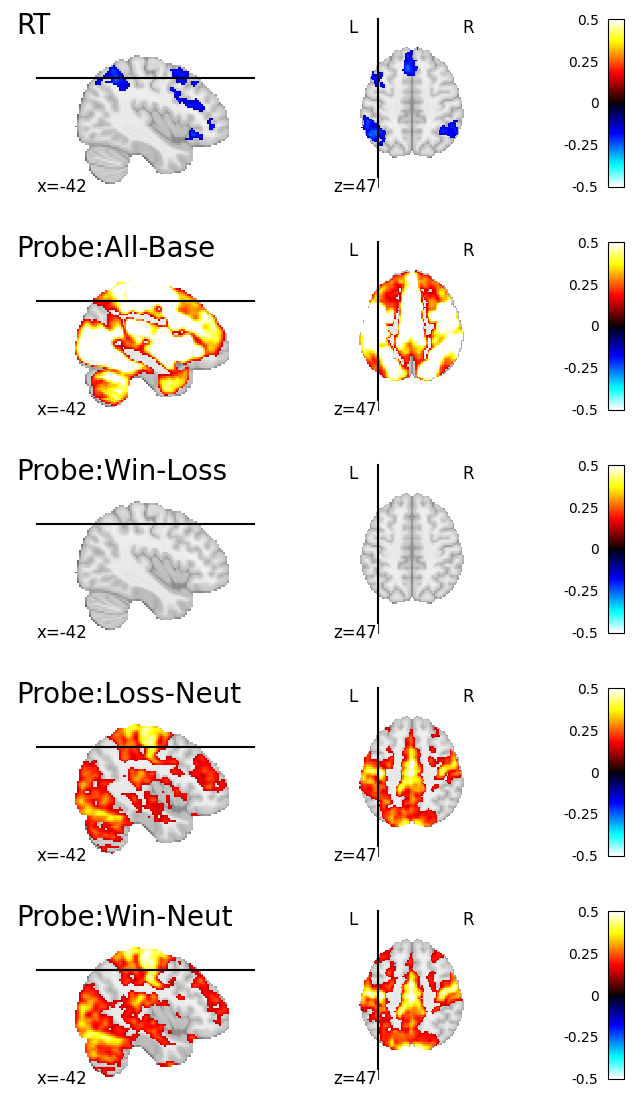

In [5]:
n_cols = 1
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 14))

for i, con in enumerate(['RT', 'Probe:All-Base','Probe:Win-Loss','Probe:Loss-Neut','Probe:Win-Neut']):
        con_img = glob(f'{grpmap_path}/custom/outmaps/{con}/subs-*_contrast-{con}_mod-Saturated_perm-cohensd.nii.gz')[0]
        row = i  # Use i as row index
        col = 1  # Use j as column index
        fig = plotting.plot_stat_map(stat_map_img=con_img, cut_coords=(-42,47),
                               display_mode="xz",
                               title=f"{con}", draw_cross=True,
                               vmin=-0.5,vmax=0.5,
                               colorbar=True, axes=axes[row])
        fig.title(f"{con}", size=20, color='black', bgcolor='white', alpha=1) # set ind fig title size, remove background


plt.savefig(f'{fig_out}/perm_probes-avg_effect.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 5. Example RT Design Matrix (w/o cosine+mot)

In this section, we create design matrices, VIFs and contrast examples for a single subject. At the end of the section, the VIFs are calculated for all of the N = 500 subjects in the model.

In [5]:
beh_n1 = glob(f'{beh_path}/*_task-MID_run-01_events.tsv')[3]

In [6]:
events_df = pd.read_csv(beh_n1,sep='\t')
events_df.columns

Index(['Subject', 'Handedness', 'SessionDate', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Cue.OnsetToOnsetTime',
       'Anticipation.Duration', 'Anticipation.OnsetTime',
       'Anticipation.OnsetToOnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.OnsetToOnsetTime', 'TextDisplay1.OnsetTime',
       'TextDisplay1.Duration', 'TextDisplay1.OnsetToOnsetTime', 'moneyamt',
       'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'Feedback.OnsetToOnsetTime', 'Probe.RESP', 'TextDisplay1.RESP',
       'Feedback.RESP', 'OverallRT', 'TextDisplay1.RT', 'Feedback.RT',
       'Probe.RT', 'Result', 'prbacc', 'prbrt', 'meanrt', 'TriggerTime',
       'TriggerTimeAlt', 'DiffTriggerTimes', 'triggertimes_warning',
       'scantrig_col', 'calibrend_col', 'eprime_readtype', 'rt_correct'],
      dtype='object')

In [ ]:
events_df[['Probe.OnsetToOnsetTime', 'Probe.OnsetTime','rt_correct']] # rt_correct is the reestimated RT values from the e-prime data

In [ ]:
events_df[['rt_correct', 'Probe.OnsetTime']]

## 5.1 Set up condition and conditional RT examples. 

In [11]:
events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                          events_df['Condition'] + 'Hit',
                                          events_df['Condition'] + 'Miss')
events_df['Probe.Type'] = np.where(events_df['prbacc'] == 1.0,
                                   'prbhit_' + events_df['Condition'],
                                   'prbmiss_' + events_df['Condition'])

mapping = {
    'SmallLoss': 'probe_lose',
    'LargeLoss': 'probe_lose',
    'SmallWin': 'probe_win',
    'LargeWin': 'probe_win',
    'Neutral': 'probe_neut'
}

events_df['Probe.Cue'] = events_df['Condition'].map(mapping)

events_df['probe_hit_onset'] = np.where(events_df['prbacc'] == 1.0,events_df['Probe.OnsetTime'], np.nan)
events_df['probe_hit_dur'] = np.where(events_df['prbacc'] == 1.0,events_df['Probe.OnsetToOnsetTime'], np.nan)

events_df['probe_miss_onset'] = np.where(events_df['prbacc'] == 0.0,events_df['Probe.OnsetTime'], np.nan)
events_df['probe_miss_dur'] = np.where(events_df['prbacc'] == 0.0,events_df['Probe.OnsetToOnsetTime'], np.nan)

In [12]:
events_df[['Feedback.Response','rt_correct']].groupby('Feedback.Response').mean('rt_correct')

rt_correct
Feedback.Response            
LargeLossHit       347.250000
LargeLossMiss      564.000000
LargeWinHit        401.000000
LargeWinMiss       445.000000
NeutralHit         329.750000
NeutralMiss        624.333333
SmallLossHit       364.333333
SmallLossMiss      630.750000
SmallWinHit        384.500000
SmallWinMiss       682.000000

## 5.2 Set up design matrix

Create stacked conditions, onsets and durations to be used in first level. Note, we *do not* use the .Duration column from the e-prime files as this is the `target` and not `true` duration of the stimuli presented throughout the experimental runs. For more details, see the [discussion here](https://support.pstnet.com/hc/en-us/articles/115000902428-TIMING-Timing-of-E-Objects-22852#:~:text=The%20Duration%20variable,the%20TimeAudit%20feature)

In order of phases modeled:

**Cue:**
1. Condition
2. Cue.OnsetTime
3. ~~Cue.Duration~~ Cue.OnsetToOnsetTime

**Fixation:**
1. Condition
2. Fixation.OnsetTime
3. ~~Fixation.Duration~~ Fixation.OnsetToOnsetTime

**Feedback:**
1. Feedback.Response
2. Feedback.OnsetTime
3. ~~FeedbackDuration~~ Feedback.OnsetToOnsetTime

*Two probe regressor:*

Probe - Regressor 1: Probe.OnsetTime + ~~Probe.Duration~~ Probe.OnsetToOnsetTime
Prone_rt - Regressor 2: Probe.OnsetTime + rt_correct / 1000

**Probe:**
1. Constant probe cue
2. Probe.OnsetTime
3. Probe.OnsetToOnsetTime

**Probe_rt:**
1. Constant probe_rt label -- omit rows w/o response
2. Probe.OnsetTime -- omit rows w/o response
3. rt_overall -- duration is the RT time, omit rows w/o response (ms --> sec). Using rt_overall instead of 'OverallRT' as OverallRT values appear to be incorrect.



In [13]:
def create_design_matrix(frametimes, eventsdf, model_type):

    # create a delinated hit v miss column so it is more clear + probe specific dichotomization
    new_feedback_label = 'Feedback.Response'
    eventsdf[new_feedback_label] = np.where(eventsdf['prbacc'] == 1.0,
                                             eventsdf['Condition'] + 'Hit',
                                             eventsdf['Condition'] + 'Miss')

    eventsdf['Probe.Type'] = np.where(eventsdf['prbacc'] == 1.0,
                                       'prbhit_' + eventsdf['Condition'],
                                       'prbmiss_' + eventsdf['Condition'])

    mapping = {
        'SmallLoss': 'probe_lose',
        'LargeLoss': 'probe_lose',
        'SmallWin': 'probe_win',
        'LargeWin': 'probe_win',
        'Neutral': 'probe_neut'
    }
    
    events_df['Probe.Cue'] = events_df['Condition'].map(mapping)

    if model_type is None:
        # CONDITIONS
        conditions = pd.concat([eventsdf.loc[:, "Condition"], eventsdf.loc[:, new_feedback_label]],
                               ignore_index=True)
        # ONSETS
        onsets = pd.concat([eventsdf.loc[:, 'Cue.OnsetTime'], eventsdf.loc[:, "Feedback.OnsetTime"]],
                           ignore_index=True)
        # DURATIONS
        duration = pd.concat([eventsdf.loc[:, 'Cue.OnsetToOnsetTime'], eventsdf.loc[:, "Feedback.OnsetToOnsetTime"]],
                             ignore_index=True)
        # create pandas df with events
        design_events = pd.DataFrame({'trial_type': conditions,
                                      'onset': onsets,
                                      'duration': duration})
    elif model_type == 'CueNoDeriv':
        # CONDITIONS
        conditions = pd.concat([eventsdf.loc[:, 'Condition'],
                                eventsdf.loc[:, new_feedback_label]],
                               ignore_index=True)
        # ONSETS
        onsets = pd.concat([eventsdf.loc[:, 'Cue.OnsetTime'],
                            eventsdf.loc[:, 'Feedback.OnsetTime']],
                           ignore_index=True)
        # DURATIONS
        durations = pd.Series([0] * len(onsets))
        design_events = pd.DataFrame({'trial_type': conditions,
                                      'onset': onsets,
                                      'duration': durations})

    elif model_type == 'CueYesDeriv':
        # CONDITIONS
        conditions = pd.concat([eventsdf.loc[:, 'Condition'],
                                eventsdf.loc[:, new_feedback_label]],
                               ignore_index=True)
        # ONSETS
        onsets = pd.concat([eventsdf.loc[:, 'Cue.OnsetTime'],
                            eventsdf.loc[:, 'Feedback.OnsetTime']],
                           ignore_index=True)
        # DURATIONS
        durations = pd.Series([0] * len(onsets))
        design_events = pd.DataFrame({'trial_type': conditions,
                                      'onset': onsets,
                                      'duration': durations})

    if model_type == 'Saturated':
        # concat  cue onset/duration + feedback onset/duration + probe regressors
        # CONDITIONS
        conditions = pd.concat([eventsdf.loc[:, "Condition"], # Cue Regressors
                                'Fix' + eventsdf.loc[:, 'Condition'], # Fixation Regressors
                                eventsdf.loc[:, new_feedback_label], # Feedback Regressors
                                #pd.Series(["probe"] * len(eventsdf[['rt_correct', 'Probe.OnsetTime']])), # Probe regressors
                                eventsdf.loc[:, "Probe.Cue"], # Probe by Cue Regressors
                                pd.Series(["probe_rt"] * len(eventsdf[['rt_correct', 'Probe.OnsetTime']].dropna())) # RT regressors
                                ], ignore_index=True)
        
        # ONSETS
        onsets = pd.concat([eventsdf.loc[:, 'Cue.OnsetTime'], # Cue Regressors
                            eventsdf.loc[:, 'Anticipation.OnsetTime'], # Fixation Regressors
                            eventsdf.loc[:, "Feedback.OnsetTime"], # Feedback Regressors
                            eventsdf.loc[:, "Probe.OnsetTime"], # Probe regressors
                            eventsdf[['rt_correct', 'Probe.OnsetTime']].dropna()['Probe.OnsetTime'] # RT regressors
                            ], ignore_index=True)
        # DURATIONS
        durations = pd.concat([eventsdf.loc[:, 'Cue.OnsetToOnsetTime'], # Cue Regressors
                              eventsdf.loc[:, 'Anticipation.OnsetToOnsetTime'], # Fixation Regressors
                              eventsdf.loc[:, "Feedback.OnsetToOnsetTime"], # Feedback Regressors
                              eventsdf.loc[:, "Probe.OnsetToOnsetTime"], # Probe regressors
                              (eventsdf[['rt_correct', 'Probe.OnsetTime']].dropna()['rt_correct']) / 1000 # RT regressors
                              ], ignore_index=True)

        # create pandas df with events
        design_events = pd.DataFrame({
            'trial_type': conditions,
            'onset': onsets,
            'duration': durations
        })

    design_matrix = make_first_level_design_matrix(
        frame_times=frametimes,
        events=design_events,
        hrf_model='spm + derivative' if model_type == 'CueYesDeriv' else 'spm',
        oversampling=10,
        drift_model=None,
        add_regs=None
    )
            
    return design_events, design_matrix

# Function to compute VIFs
def compute_vifs(design_matrix):
    vif_data = pd.DataFrame()
    vif_data['Var'] = design_matrix.columns
    vif_data['VIF'] = [variance_inflation_factor(design_matrix.values, i) for i in range(design_matrix.shape[1])]
    return vif_data

In [14]:
# vols / tr
num_volumes = 403
bold_tr = .800

# Using the BOLD tr and volumes to generate the frame_times: acquisition time in seconds
frame_times = np.arange(num_volumes) * bold_tr

### 5.2.1 CueYesDeriv Design Matrix

In [12]:
def spmg1(t):
    A1 = 0.0083333333
    P1 = 5
    A2 = 1.274527e-13
    P2 = 15
    return np.exp(-t) * (A1 * t**P1 - A2 * t**P2)

Hagler et al. ([2019](www.doi.d10.1016/j.neuroimage.2019.116091)), states that the task fMRI models provided by the DAIRC: task*Hemodynamic response functions are modelled with two parameters using a gamma variate basis function plus its temporal derivative (using AFNI’s ‘SPMG’ option within 3dDeconvolve).... For MID and SST analyses, events are modelled as instantaneous*". 
Based on [AFNI's documentation](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dDeconvolve.html), the stick is convolved with the two parameters (SPMG2). Thus, for each regressor in the design matrix there is parameter for the gamma function. The conditional contrast provided by DAIRC is based on the gamma function and derivative is ignored.


The spm and afni spmg1 HRF's are identical as demonstrated below curtosy of Dr Mumford's code.

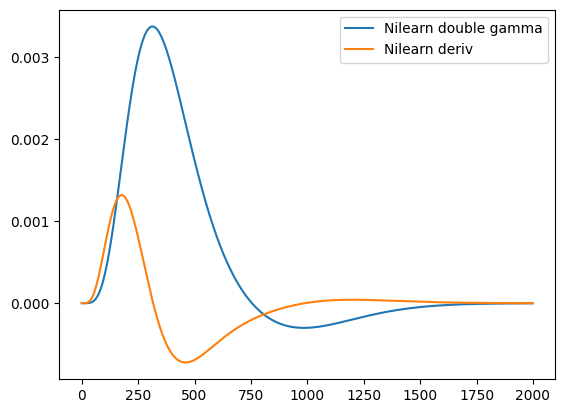

In [13]:
nilearn_hrf = _gamma_difference_hrf(.8)
nilearn_deriv = spm_time_derivative(.8)
plt.plot(nilearn_hrf, label='Nilearn double gamma')
plt.plot(nilearn_deriv, label='Nilearn deriv')

plt.legend()
plt.show()

In [ ]:
design_cue, design_matrix_cue = create_design_matrix(frametimes=frame_times,
                                  eventsdf=events_df, model_type='CueYesDeriv')
vif_cueyesderiv = compute_vifs(design_matrix_cue)#.drop(columns=['constant'])

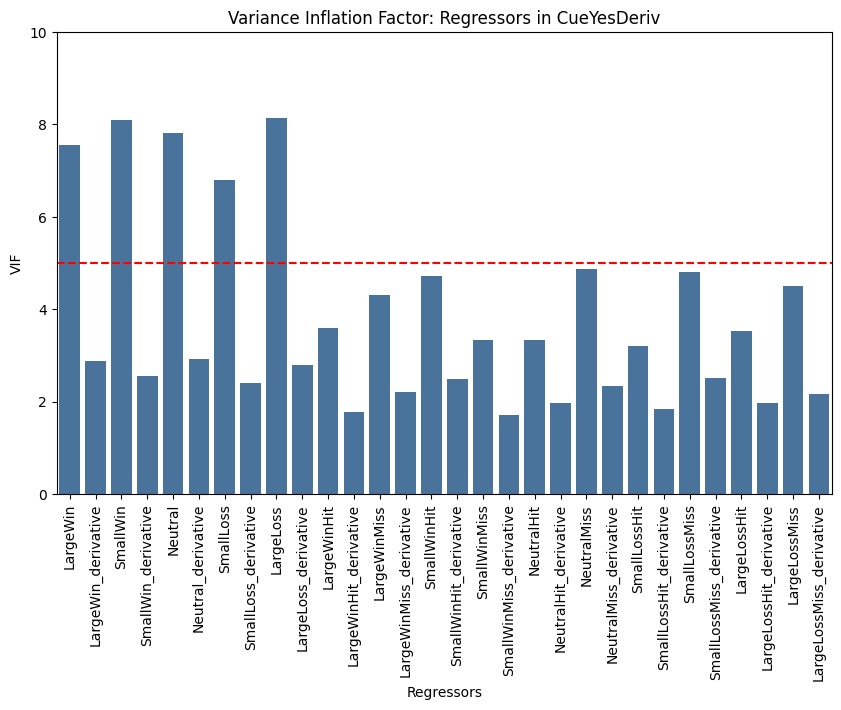

In [17]:
model = 'CueYesDeriv'
cueyesderiv_cols = [
    'LargeWin', 'LargeWin_derivative',
    'SmallWin', 'SmallWin_derivative',
    'Neutral', 'Neutral_derivative',
    'SmallLoss', 'SmallLoss_derivative',
    'LargeLoss', 'LargeLoss_derivative',
    'LargeWinHit', 'LargeWinHit_derivative',
    'LargeWinMiss', 'LargeWinMiss_derivative',
    'SmallWinHit', 'SmallWinHit_derivative',
    'SmallWinMiss', 'SmallWinMiss_derivative',
    'NeutralHit', 'NeutralHit_derivative',
    'NeutralMiss', 'NeutralMiss_derivative',
    'SmallLossHit', 'SmallLossHit_derivative',
    'SmallLossMiss', 'SmallLossMiss_derivative',
    'LargeLossHit', 'LargeLossHit_derivative',
    'LargeLossMiss', 'LargeLossMiss_derivative'
]

plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', data=vif_cueyesderiv, order = cueyesderiv_cols, color='#3c73a8')
plt.ylim(0,10)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {model}')
plt.xticks(rotation=90, fontsize=10)  
plt.show()

### 6.2.2 Saturated (RT) Design Matrix

In [18]:
design_sat, design_matrix_sat = create_design_matrix(frametimes=frame_times,
                                  eventsdf=events_df, model_type='Saturated')
vif_saturated = compute_vifs(design_matrix_sat)

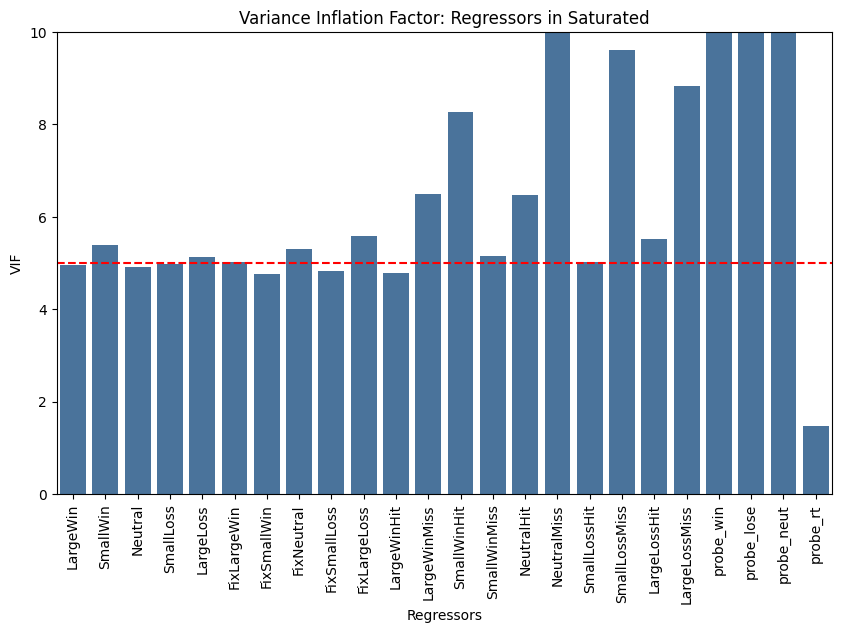

In [19]:
model = 'Saturated'
sat_cols = ['LargeWin', 'SmallWin', 'Neutral', 'SmallLoss', 'LargeLoss',
                'FixLargeWin', 'FixSmallWin', 'FixNeutral', 'FixSmallLoss', 'FixLargeLoss',
                'LargeWinHit', 'LargeWinMiss', 'SmallWinHit', 'SmallWinMiss',
                'NeutralHit', 'NeutralMiss', 'SmallLossHit', 'SmallLossMiss',
                'LargeLossHit', 'LargeLossMiss', 'probe_win', 'probe_lose','probe_neut','probe_rt']

plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', data=vif_saturated, order = sat_cols, color='#3c73a8')
plt.ylim(0,10)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {model}')
plt.xticks(rotation=90, fontsize=10)  
plt.show()

### SUPPLEMENTAL Figure Comparing HRF + MAPS + Events

In [ ]:
events_df[events_df['Condition'] == "LargeWin"]

Text(0, 0.5, 'Amplitude')

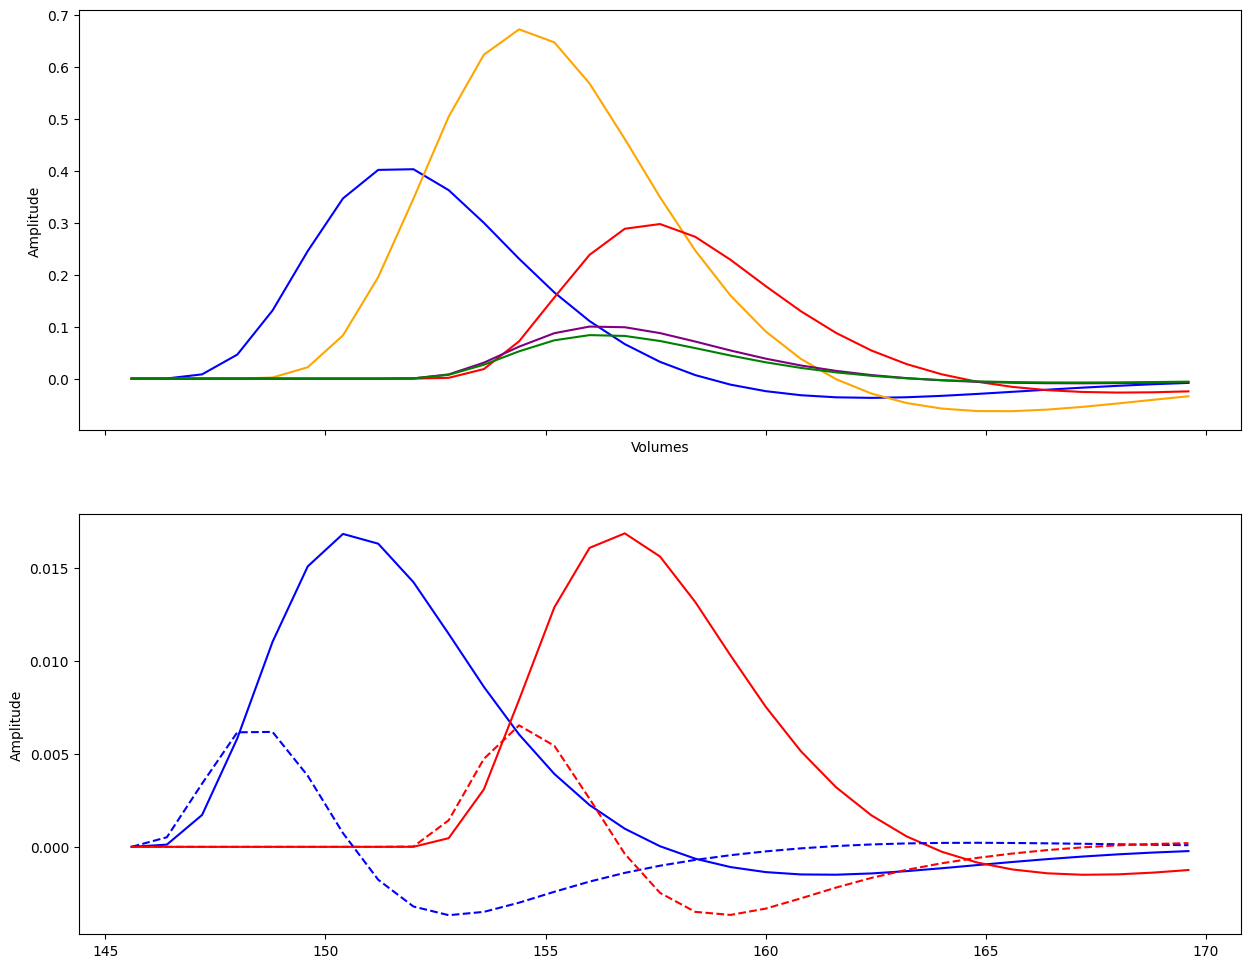

In [25]:
sub_gain = pd.DataFrame(events_df.loc[[22],:]) # get only Gain hit trial

a, b = create_design_matrix(frametimes=frame_times, eventsdf=sub_gain, model_type='Saturated')
c_a, c_b = create_design_matrix(frametimes=frame_times, eventsdf=sub_gain, model_type='CueYesDeriv')

# set start / end in vols
start = 145
end = 170
import matplotlib as mpl

# Set global font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Create a single figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(15, 12), sharex=True)

axes[0].plot(b.loc[start:end, ['LargeWin']], color='blue')
axes[0].plot(b.loc[start:end, ['FixLargeWin']], color='orange')
axes[0].plot(b.loc[start:end, ['LargeWinHit']], color='red')
axes[0].plot(b.loc[start:end, ['probe_win']], color='purple')

axes[0].plot(b.loc[start:end, ['probe_rt']], color='green')
axes[0].set_xlabel('Volumes')
axes[0].set_ylabel('Amplitude')

axes[1].plot(c_b.loc[start:end, 'LargeWin'], color='blue')
axes[1].plot(c_b.loc[start:end, 'LargeWinHit'], color='red')
axes[1].plot(c_b.loc[start:end, 'LargeWin_derivative'], linestyle='--', color='blue')
axes[1].plot(c_b.loc[start:end, 'LargeWinHit_derivative'], linestyle='--', color='red')
axes[1].set_ylabel('Amplitude')


## 5.3 Model [Design] Illustrations

In [26]:
events_df.columns

Index(['Subject', 'Handedness', 'SessionDate', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Cue.OnsetToOnsetTime',
       'Anticipation.Duration', 'Anticipation.OnsetTime',
       'Anticipation.OnsetToOnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.OnsetToOnsetTime', 'TextDisplay1.OnsetTime',
       'TextDisplay1.Duration', 'TextDisplay1.OnsetToOnsetTime', 'moneyamt',
       'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'Feedback.OnsetToOnsetTime', 'Probe.RESP', 'TextDisplay1.RESP',
       'Feedback.RESP', 'OverallRT', 'TextDisplay1.RT', 'Feedback.RT',
       'Probe.RT', 'Result', 'prbacc', 'prbrt', 'meanrt', 'TriggerTime',
       'TriggerTimeAlt', 'DiffTriggerTimes', 'triggertimes_warning',
       'scantrig_col', 'calibrend_col', 'eprime_readtype', 'rt_correct',
       'Probe.Cue', 'Feedback.Response', 'Probe.Type'],
      dtype='object')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


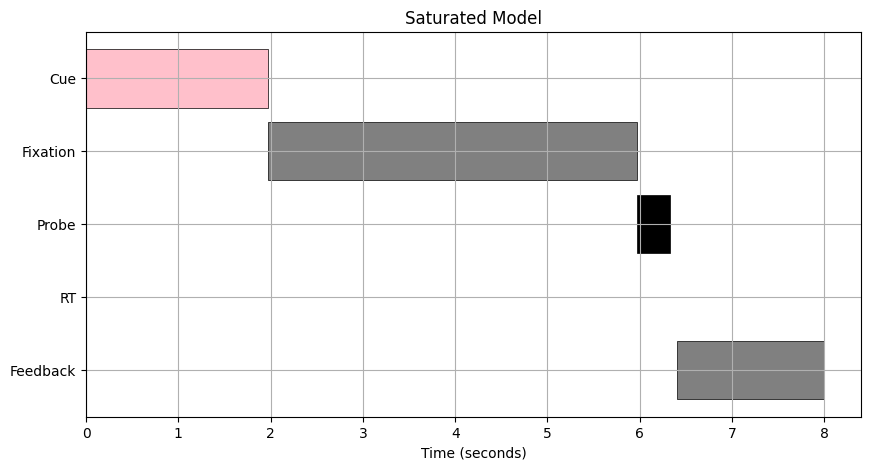

In [27]:
ex_df = events_df.copy()
ex_df['rt_dur'] = ex_df['rt_correct']/1000
for sub_on in ['Anticipation.OnsetTime','Probe.OnsetTime','Feedback.OnsetTime']:
    ex_df[sub_on] = ex_df[sub_on] - ex_df['Cue.OnsetTime']
ex_df['Cue.OnsetTime'] = ex_df['Cue.OnsetTime'] - ex_df['Cue.OnsetTime']
ex_df['Combined.Duration'] = ex_df['Cue.OnsetToOnsetTime'] + ex_df['Anticipation.OnsetToOnsetTime']
    
ex_df[['Cue.OnsetTime','Cue.OnsetToOnsetTime','Combined.Duration',
       'Anticipation.OnsetTime','Anticipation.OnsetToOnsetTime',
       'Probe.OnsetTime','Probe.OnsetToOnsetTime',
       'Probe.OnsetTime','rt_dur',
       'Feedback.OnsetTime', 'Feedback.OnsetToOnsetTime']].iloc[1]

fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for the bars
colors = ['pink', 'grey', 'black', 'black', 'grey']  # Fill colors for Cue, Anticipation, and Feedback
outline_color = 'black'  # Color for the outlines

labels = ['Feedback', 'RT', 'Probe', 'Fixation', 'Cue']
values = ex_df[['Feedback.OnsetToOnsetTime', 'rt_dur', 'Probe.OnsetToOnsetTime', 'Anticipation.OnsetToOnsetTime', 'Cue.OnsetToOnsetTime']].iloc[1]
lefts = ex_df[['Feedback.OnsetTime', 'Probe.OnsetTime', 'Probe.OnsetTime', 'Anticipation.OnsetTime', 'Cue.OnsetTime']].iloc[1]

bars = ax.barh(
    labels,
    values,
    left=lefts,
    color=[colors[4], colors[3], colors[2], colors[1], colors[0]],  # fill for bars
    edgecolor=[outline_color] * len(labels),  # outlines for all bars
    linewidth=0.5  
)

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Saturated Model')
ax.grid(True)

# Show the plot
plt.show()

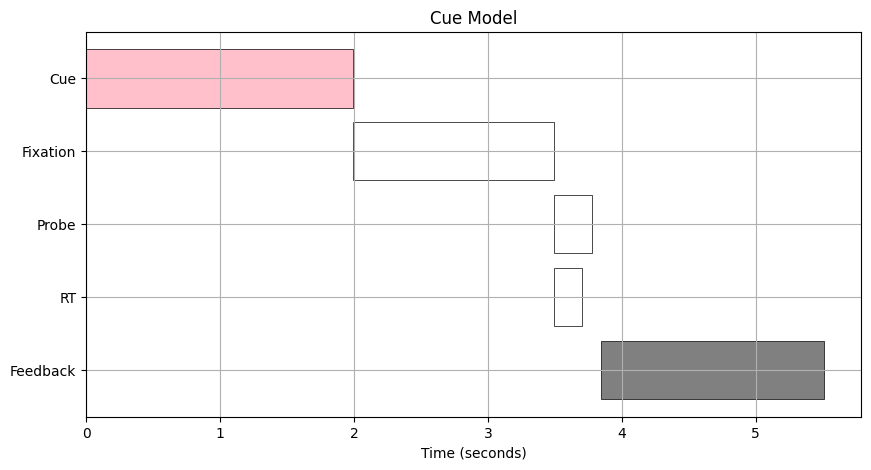

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for the bars
colors = ['pink', 'grey', 'black', 'black', 'grey']  # Fill colors for Cue, Anticipation, and Feedback
outline_color = 'black'  # Color for the outlines

labels = ['Feedback', 'RT', 'Probe', 'Fixation', 'Cue']
values = ex_df[['Feedback.OnsetToOnsetTime', 'rt_dur', 'Probe.OnsetToOnsetTime', 'Anticipation.OnsetToOnsetTime', 'Cue.OnsetToOnsetTime']].iloc[1]
lefts = ex_df[['Feedback.OnsetTime', 'Probe.OnsetTime', 'Probe.OnsetTime', 'Anticipation.OnsetTime', 'Cue.OnsetTime']].iloc[1]

bars = ax.barh(
    labels,
    values,
    left=lefts,
    color=[colors[4], 'none', 'none', 'none', colors[0]],  # fill for bars
    edgecolor=[outline_color] * len(labels),  # outlines for all bars
    linewidth=0.5  
)

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Cue Model')
ax.grid(True)

# Show the plot
plt.show()

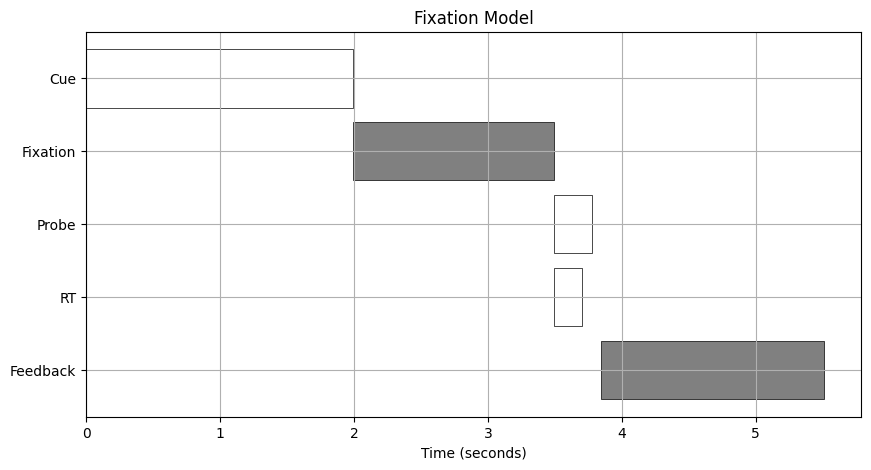

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for the bars
colors = ['pink', 'grey', 'black', 'black', 'grey']  # Fill colors for Cue, Anticipation, and Feedback
outline_color = 'black'  # Color for the outlines

labels = ['Feedback', 'RT', 'Probe', 'Fixation', 'Cue']
values = ex_df[['Feedback.OnsetToOnsetTime', 'rt_dur', 'Probe.OnsetToOnsetTime', 'Anticipation.OnsetToOnsetTime', 'Cue.OnsetToOnsetTime']].iloc[1]
lefts = ex_df[['Feedback.OnsetTime', 'Probe.OnsetTime', 'Probe.OnsetTime', 'Anticipation.OnsetTime', 'Cue.OnsetTime']].iloc[1]

bars = ax.barh(
    labels,
    values,
    left=lefts,
    color=[colors[4], 'none', 'none', colors[1], 'none'],  # fill for bars
    edgecolor=[outline_color] * len(labels),  # outlines for all bars
    linewidth=0.5  
)

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Fixation Model')
ax.grid(True)

# Show the plot
plt.show()

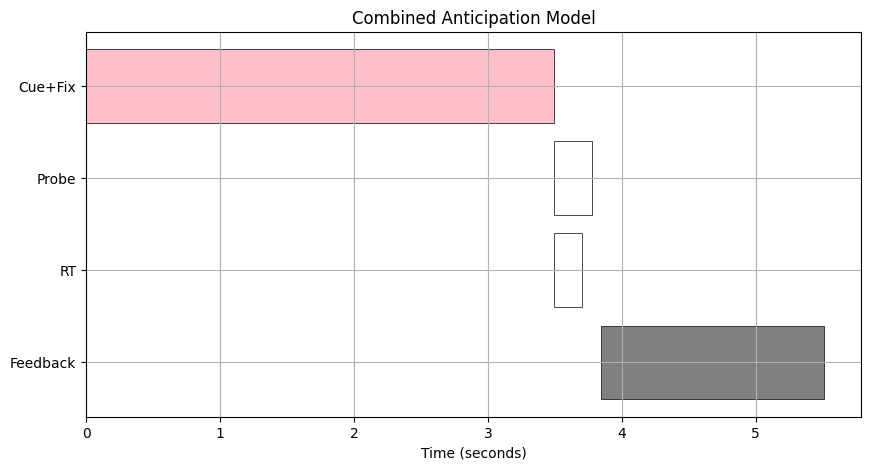

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for the bars
colors = ['pink', 'grey', 'black', 'black', 'grey']  # Fill colors for Cue, Anticipation, and Feedback
outline_color = 'black'  # Color for the outlines

labels = ['Feedback', 'RT', 'Probe', 'Cue+Fix']
values = ex_df[['Feedback.OnsetToOnsetTime', 'rt_dur', 'Probe.OnsetToOnsetTime', 'Combined.Duration']].iloc[1]
lefts = ex_df[['Feedback.OnsetTime', 'Probe.OnsetTime', 'Probe.OnsetTime', 'Cue.OnsetTime']].iloc[1]

bars = ax.barh(
    labels,
    values,
    left=lefts,
    color=[colors[4], 'none','none', colors[0]],  # fill for bars
    edgecolor=[outline_color] * len(labels),  # outlines for all bars
    linewidth=0.5  
)

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Combined Anticipation Model')
ax.grid(True)

# Show the plot
plt.show()

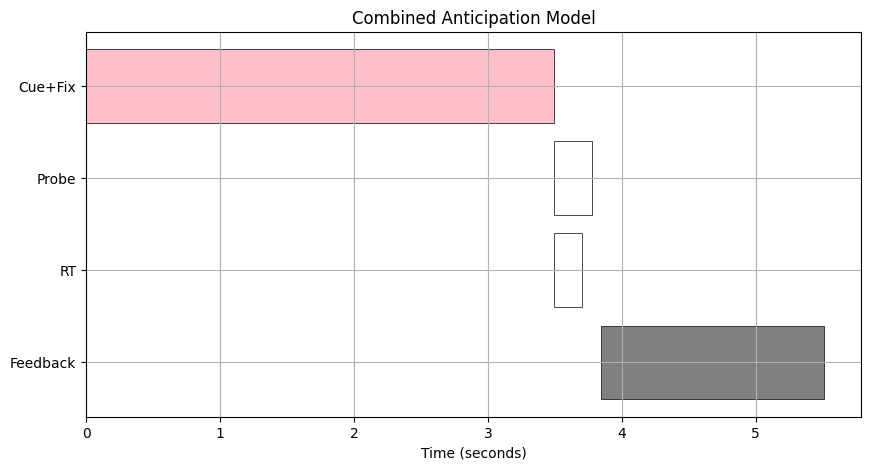

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define colors for the bars
colors = ['pink', 'grey', 'black', 'black', 'grey']  # Fill colors for Cue, Anticipation, and Feedback
outline_color = 'black'  # Color for the outlines

labels = ['Feedback', 'RT', 'Probe', 'Cue+Fix']
values = ex_df[['Feedback.OnsetToOnsetTime', 'rt_dur', 'Probe.OnsetToOnsetTime', 'Combined.Duration']].iloc[1]
lefts = ex_df[['Feedback.OnsetTime', 'Probe.OnsetTime', 'Probe.OnsetTime', 'Cue.OnsetTime']].iloc[1]

bars = ax.barh(
    labels,
    values,
    left=lefts,
    color=[colors[4], 'none','none', colors[0]],  # fill for bars
    edgecolor=[outline_color] * len(labels),  # outlines for all bars
    linewidth=0.5  
)

# Set labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Combined Anticipation Model')
ax.grid(True)

# Show the plot
plt.show()

## 5.4 Plot design matrices for models

Create nilean design matrix for n volumes + bold TR in MID ABCD w/o slice-time correction, using an SPM model. The SPM model for `CueYesDeriv` also includes a temporal derivative for each regressor. 
Full analyses of the data include drift parameters calculated by fmriprep + x,y,z + derivatives motion regressors

### 5.4.1 `CueYesDeriv Design matrix`

In [31]:
cols_labs = cueyesderiv_cols + ['constant']

design_matrix_cue = design_matrix_cue.reindex(columns=cols_labs)
print("Size of design matrix minus intercept:", design_matrix_cue.shape[-1]-1)

Size of design matrix minus intercept: 30


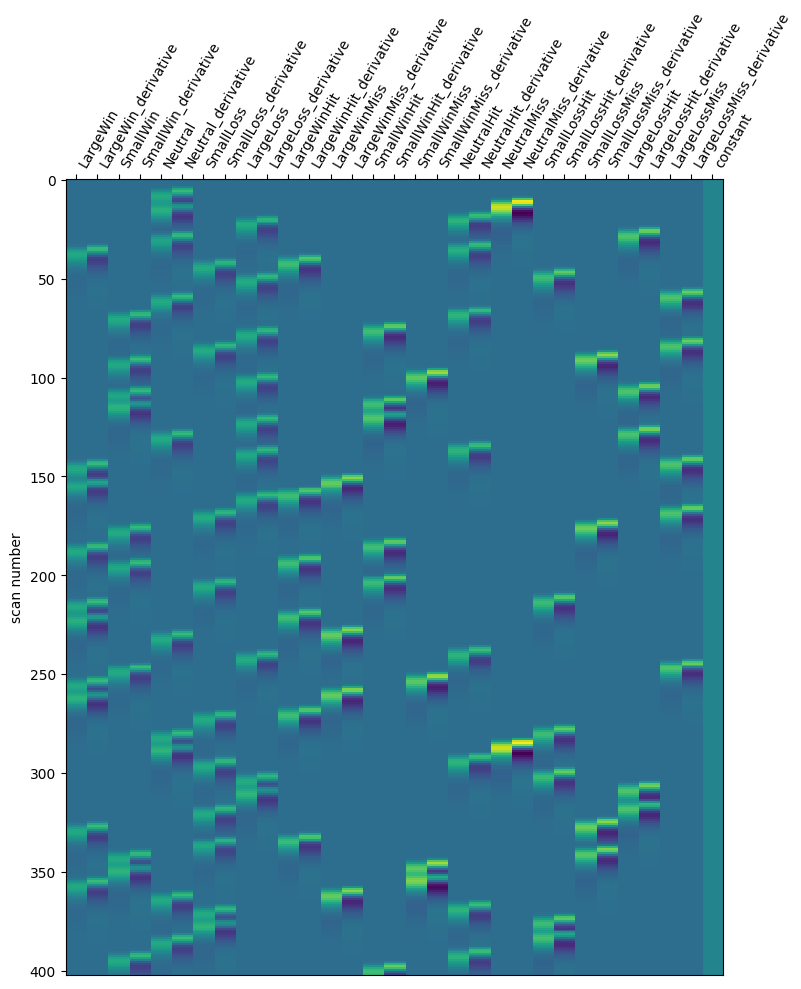

In [32]:
plotting.plot_design_matrix(design_matrix_cue)
plt.savefig(f'{fig_out}/designmat_mod-CueYesDeriv.pdf', format='pdf')

### 5.4.2 `Saturated` Model Design matrix

In [28]:
reorder_cols = sat_cols + ['constant']
design_matrix_sat = design_matrix_sat.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_sat.shape[-1]-1)

Size of design matrix minus intercept: 24


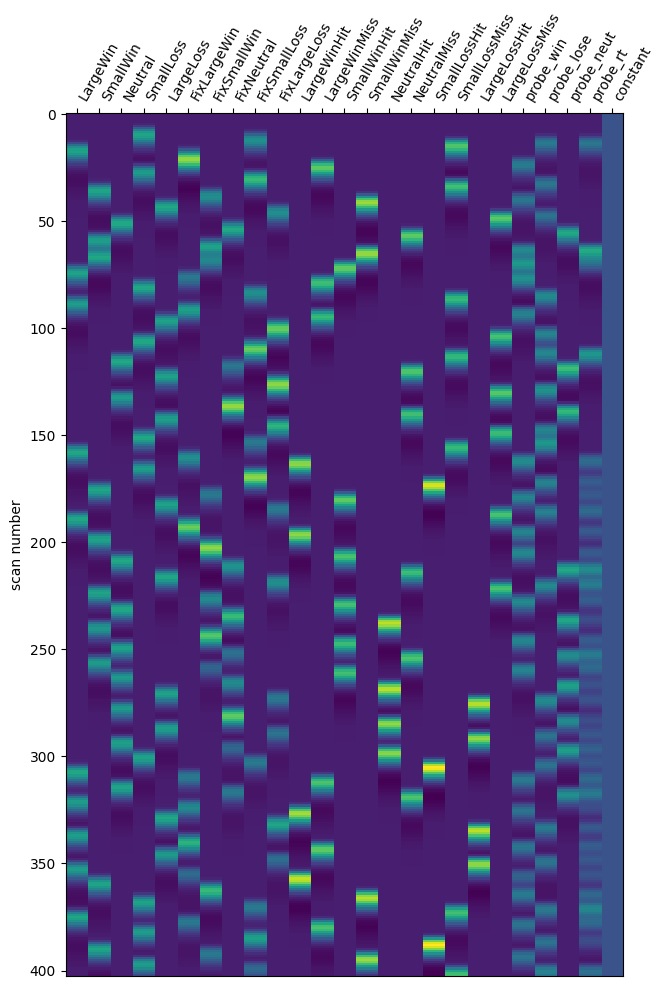

In [29]:
plotting.plot_design_matrix(design_matrix_sat, rescale=True)
plt.savefig(f'{fig_out}/designmat_mod-Saturated.pdf', format='pdf')

## 5.5 Distribution of VIFs across models

In [33]:
all_vifs = {
    'CueYesDeriv': [],
    'CueNoDeriv': [],
    'Saturated': []
}

frame_times = frame_times 
sub_df = pd.read_csv(sub_list, sep='\t',header=None)

if os.path.exists(f'{out_path}/model_vif_comp.csv'):
    vif_all = pd.read_csv(f'{out_path}/model_vif_comp.csv',sep=',')
else:
    for sub in sub_df[0]: 
        for run in ['01','02']:
            events_df = pd.read_csv(f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-{run}_events.tsv',
                                    sep='\t')
            events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                                      events_df['Condition'] + 'Hit',
                                                      events_df['Condition'] + 'Miss')
            
            # Generate design matrices for each model type
            _, design_matrix_cueyes = create_design_matrix(frametimes=frame_times, eventsdf=events_df, model_type="CueYesDeriv")
            _, design_matrix_cueno = create_design_matrix(frametimes=frame_times, eventsdf=events_df,  model_type="CueNoDeriv")
            _, design_matrix_sat = create_design_matrix(frametimes=frame_times, eventsdf=events_df,  model_type="Saturated")
            
            
            # Compute VIFs for each model
            vif_cueyes = compute_vifs(design_matrix_cueyes) #.drop(columns=['constant'])
            vif_cueno = compute_vifs(design_matrix_cueno)
            vif_sat = compute_vifs(design_matrix_sat)

            
            # Store the VIFs
            all_vifs['CueYesDeriv'].append(vif_cueyes)
            all_vifs['CueNoDeriv'].append(vif_cueno)
            all_vifs['Saturated'].append(vif_sat)
            
    
    vif_cueyes_pd = pd.concat(all_vifs['CueYesDeriv'], ignore_index=True)
    vif_cueno_pd =  pd.concat(all_vifs['CueNoDeriv'], ignore_index=True)
    vif_sat_pd =  pd.concat(all_vifs['Saturated'], ignore_index=True)
    
    vif_cueyes_pd['Model'] = 'CueYesDeriv'
    vif_cueno_pd['Model'] = 'CueNoDeriv'
    vif_sat_pd['Model'] = 'Saturated'
    
    
    vif_all = pd.concat([vif_cueyes_pd, vif_cueno_pd, vif_sat_pd])
    vif_all = vif_all[vif_all['Var'] != 'constant']
    vif_all.to_csv(f'{out_path}/model_vif_comp.csv',sep=',', index=False)

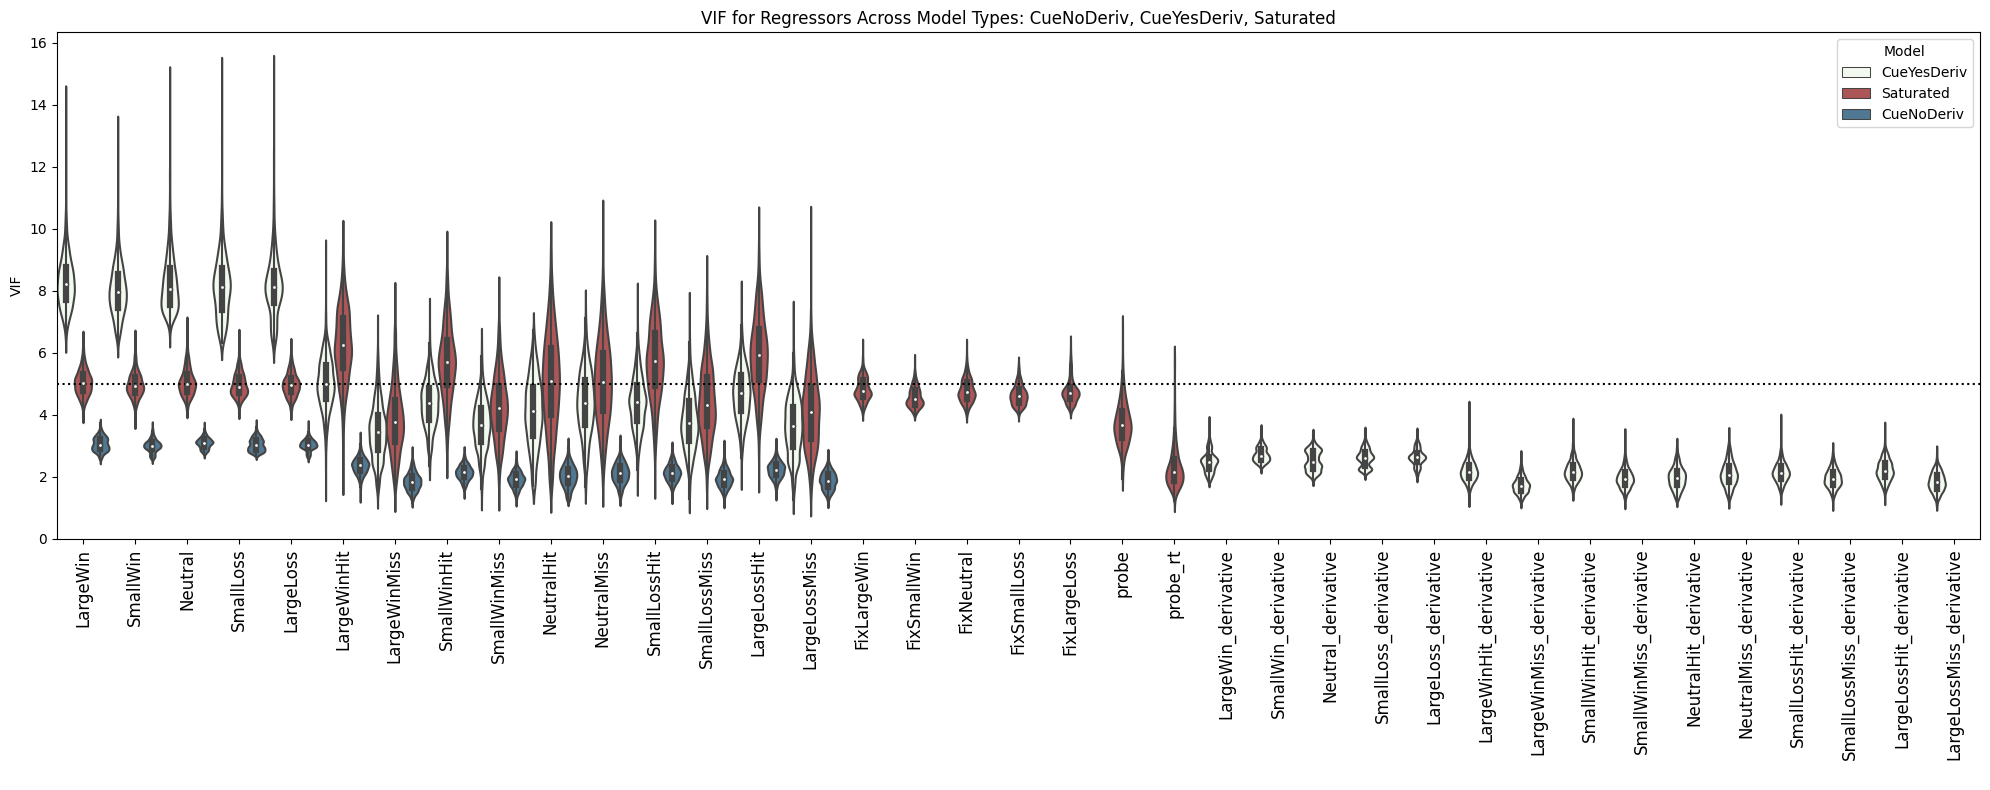

In [32]:
var_order = [
    'LargeWin', 'SmallWin', 'Neutral','SmallLoss','LargeLoss',
    'LargeWinHit', 'LargeWinMiss', 'SmallWinHit', 'SmallWinMiss',
    'NeutralHit', 'NeutralMiss', 
    'SmallLossHit', 'SmallLossMiss', 'LargeLossHit', 'LargeLossMiss',
    'FixLargeWin','FixSmallWin','FixNeutral',
    'FixSmallLoss','FixLargeLoss',
    'probe','probe_rt',
    'LargeWin_derivative','SmallWin_derivative',
    'Neutral_derivative','SmallLoss_derivative', 'LargeLoss_derivative',
     'LargeWinHit_derivative','LargeWinMiss_derivative','SmallWinHit_derivative',
    'SmallWinMiss_derivative','NeutralHit_derivative','NeutralMiss_derivative',
    'SmallLossHit_derivative','SmallLossMiss_derivative','LargeLossHit_derivative',
    'LargeLossMiss_derivative',
]
palette = {'CueYesDeriv': '#f1faee',   
           'CueNoDeriv': '#457b9d',    
           'Saturated': '#bc4749'}     
plt.figure(figsize=(20, 8))
sns.violinplot(x='Var', y='VIF', hue='Model', order=var_order,
               data=vif_all, width=1, dodge=True, scale='width', palette=palette)
plt.title('VIF for Regressors Across Model Types: CueNoDeriv, CueYesDeriv, Saturated')
plt.xticks(rotation=90, fontsize=12)
plt.xlabel(' ')
plt.axhline(y=5, color='black', linestyle='dotted')
plt.tight_layout()  # Ensure everything fits without overlap
plt.savefig(f'{fig_out}/violin-plot_vifs-modregressors_noprobe.pdf', format='pdf')
plt.show()

## 5.6 Example of contrasts and contrast matrix for `Saturated` models

In [90]:
full_contrasts_labs = {
    # CUE ANTICIPATORY
    'Cue:LW-Neut': 'LargeWin - Neutral',
    'Cue:W-Neut': 'LargeWin + SmallWin - 2*Neutral',
    'Cue:LL-Neut': 'LargeLoss - Neutral',
    'Cue:L-Neut': 'LargeLoss + SmallLoss - 2*Neutral',
    'Cue:LW-Base': 'LargeWin',
    # FIXATION ANTICIPATORY
    'Fix:LW-Neut': 'FixLargeWin - FixNeutral',
    'Fix:W-Neut': 'FixLargeWin + FixSmallWin - 2*FixNeutral',
    'Fix:LL-Neut': 'FixLargeLoss - FixNeutral',
    'Fix:L-Neut': 'FixLargeLoss + FixSmallLoss - 2*FixNeutral',
    'Fix:LW-Base': 'FixLargeWin',
    # FEEDBACK
    'FB:WHit-WMiss': 'LargeWinHit + SmallWinHit - LargeWinMiss - SmallWinMiss',
    'FB:LWHit-LWMiss': 'LargeWinHit - LargeWinMiss',
    'FB:LWHit-NeutHit': 'LargeWinHit - NeutralHit',
    'FB:LWHit-Base': 'LargeWinHit',
    'FB:LHit-LMiss': 'LargeLossHit + SmallLossHit - LargeLossMiss - SmallLossMiss',
    'FB:LLHit-LLMiss': 'LargeLossHit - LargeLossMiss',
    # probe maps
    'Probe': 'probe',
    'RT': 'probe_rt'
}


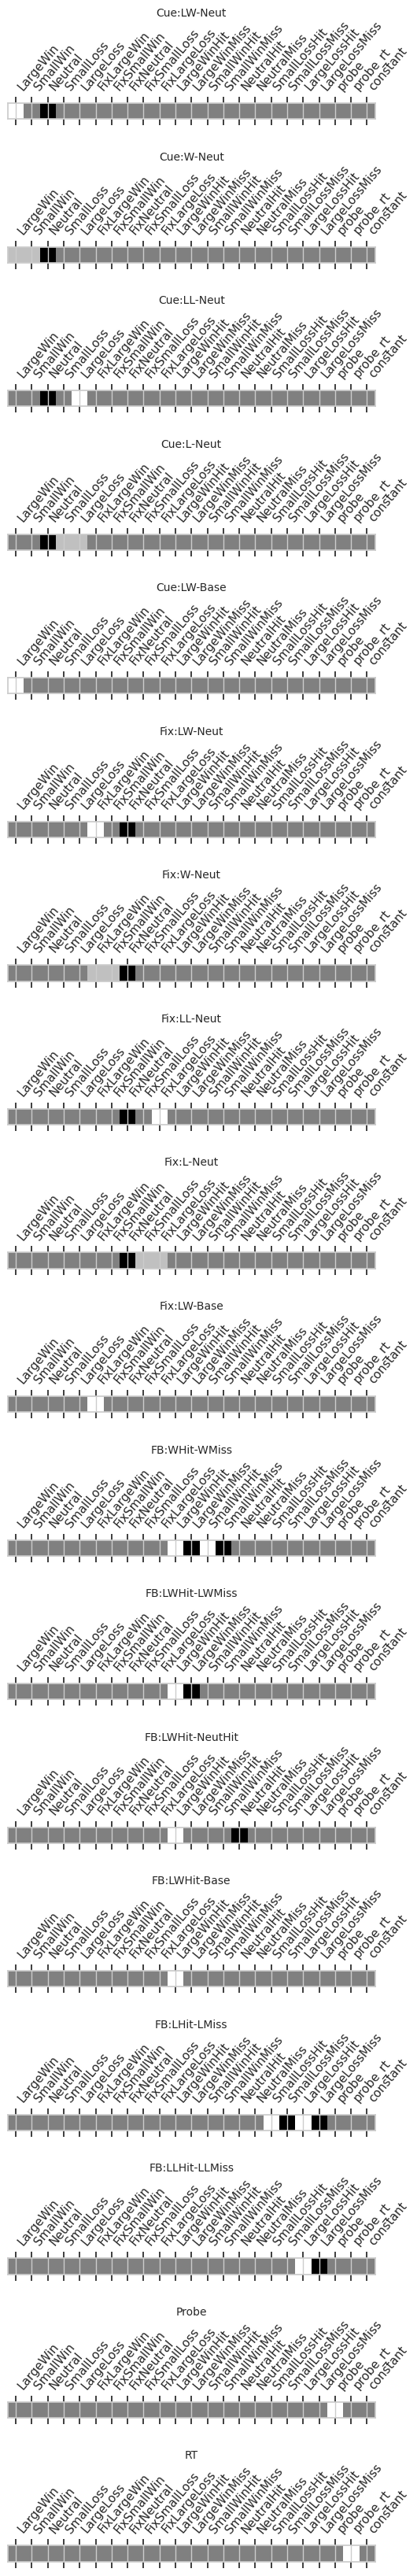

In [188]:
fig, axes = plt.subplots(nrows=len(full_contrasts_labs), ncols=1, figsize=(250, 90))

# Plot each contrast matrix on a separate subplot
for i, (key, values) in enumerate(full_contrasts_labs.items()):
    ax = axes[i]  # Select the appropriate subplot
    plotting.plot_contrast_matrix(values, design_matrix=design_matrix_sat, ax=ax)
    ax.set_title(key, fontsize=10, pad=.01)  # Set title for each subplot with smaller font size
plt.subplots_adjust(hspace=8)  # Add space between subplots
plt.savefig(f'{fig_out}/Example_contrast-weights_mod-saturated.pdf', format='pdf')

plt.show()

In [115]:
vals = design_matrix_sat.columns.values
print(' '.join(vals))

LargeWin SmallWin Neutral SmallLoss LargeLoss FixLargeWin FixSmallWin FixNeutral FixSmallLoss FixLargeLoss LargeWinHit LargeWinMiss SmallWinHit SmallWinMiss NeutralHit NeutralMiss SmallLossHit SmallLossMiss LargeLossHit LargeLossMiss probe probe_rt constant


In [117]:
for i, (key, values) in enumerate(full_contrasts_labs.items()):
    print(key,'\n',expression_to_contrast_vector(values, design_columns=design_matrix_sat.columns))

Cue:LW-Neut 
 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Cue:W-Neut 
 [ 1.  1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Cue:LL-Neut 
 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Cue:L-Neut 
 [ 0.  0. -2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Cue:LW-Base 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Fix:LW-Neut 
 [ 0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Fix:W-Neut 
 [ 0.  0.  0.  0.  0.  1.  1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Fix:LL-Neut 
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Fix:L-Neut 
 [ 0.  0.  0.  0.  0.  0.  0. -2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
Fix:LW-Base 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

# 6. Demographic, Site & Behavioral info for Sample

## 6.1 Demographic

In [3]:
from itertools import combinations

def cohens_d(mean1, std1, mean2, std2, n):
    pool_std = np.sqrt(((n - 1) * std1**2 + (n - 1) * std2**2) / (n + n - 2))
    d = (mean1 - mean2) / pool_std

    return d

In [30]:
nda_info = pd.read_csv(nda_info_file, sep='\t')
sub_df = pd.read_csv(sub_list, sep='\t',header=None)
nda_info = nda_info[nda_info['subject'].isin(sub_df[0].str.split('-', expand=True)[1])]
nda_info['age_years'] = nda_info['interview_age']/12
n = len(sub_df)

In [35]:
print(f"Average age for N = {n}: {round((nda_info['age_years']).mean(),2)} (SD: {round((nda_info['age_years']).std(),2)})")

Average age for N = 500: 12.03 (SD: 0.66)


In [36]:
round(nda_info.groupby('sex')['age_years'].agg(['count', 'mean','std','min','max']),2)

count   mean   std    min   max
sex                                 
F      235  12.01  0.67  10.67  13.5
M      265  12.04  0.66  10.83  13.5

In [37]:
nda_info.groupby('site_id_l')['site_id_l'].agg(['count'])

count
site_id_l       
site02        50
site03        45
site05        42
site06        56
site07        25
site09        41
site11        43
site12        37
site14        44
site15        10
site16        47
site20        28
site21        32

In [31]:
# remap for permutation blocks for randomize (expects ordered 1 to N. Otherwise fails
remap_dict = {
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 9: 6,
 11: 7,
 12: 8,
 14: 9,
 15: 10,
 16: 11,
 20: 12,
 21: 13
}

nda_info['subject'] = 'sub-' + nda_info['subject']
nda_info['site_numeric'] = nda_info['site_id_l'].str.extract('(\d+)').astype(int)
nda_info['site_fslrand'] = nda_info['site_numeric'].map(remap_dict)

nda_info[['subject', 'site_numeric','site_fslrand']].to_csv(
    f'{script_path}/cluster_jobs/subject_ids/site_ids.csv',
    sep=',',
    index=False
)

nda_info[['subject', 'site_numeric','site_fslrand']].to_csv(
    f'{out_path}/site_ids.csv',
    sep=',',
    index=False
)

In [38]:
nda_info.groupby('scanner')['scanner'].agg(['count'])

count
scanner       
SIEMENS    500

## 6.2 Behavioral info

In [39]:
# relabel condition names
rename_conds = {
    'LgReward': 'LargeWin',
    'SmallReward': 'SmallWin',
    'LgPun': 'LargeLoss',
    'SmallPun': 'SmallLoss',
    'Triangle': 'Neutral'
}

In [40]:
sub_df = pd.read_csv(sub_list, sep='\t',header=None)

In [41]:
combined_mrt = []
combined_acc = []
for sub in sub_df[0]: 
    r1 = pd.read_csv(f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv',sep='\t')
    r1['Condition'] = r1['Condition'].replace(rename_conds)
    r1 = create_hitmiss(r1, 'prbacc','Condition')
    r2 = pd.read_csv(f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv',sep='\t')
    r2['Condition'] = r2['Condition'].replace(rename_conds)
    r2 = create_hitmiss(r2, 'prbacc','Condition')

    # mrt
    ant_mrt_r1 = r1.groupby(['Subject','Run','Condition'])['rt_correct'].mean().reset_index()
    ant_mrt_r2 = r2.groupby(['Subject','Run','Condition'])['rt_correct'].mean().reset_index()
    fb_mrt_r1 = r1.groupby(['Subject','Run','Feedback.Response'])['rt_correct'].mean().reset_index()
    fb_mrt_r2 = r2.groupby(['Subject','Run','Feedback.Response'])['rt_correct'].mean().reset_index()
    condition_mrt = pd.concat([ant_mrt_r1, ant_mrt_r2,fb_mrt_r1,fb_mrt_r2])
    combined_mrt.append(condition_mrt)
    # acc
    ant_acc_r1 = r1.groupby(['Subject','Run','Condition'])['prbacc'].mean().reset_index()
    ant_acc_r2 = r2.groupby(['Subject','Run','Condition'])['prbacc'].mean().reset_index()
    fb_acc_r1 = r1.groupby(['Subject','Run','Feedback.Response'])['prbacc'].mean().reset_index()
    fb_acc_r2 = r2.groupby(['Subject','Run','Feedback.Response'])['prbacc'].mean().reset_index()
    condition_acc = pd.concat([ant_acc_r1, ant_acc_r2,fb_acc_r1,fb_acc_r2])
    combined_acc.append(condition_acc)


In [50]:
final_mrt = pd.concat(combined_mrt)
final_acc = pd.concat(combined_acc)

### 6.2.1 mean RTs overall and across conditions

In [43]:
mrt_out = round(final_mrt.groupby(['Condition'])['rt_correct'].agg(['mean','std']),2)
round(final_mrt.groupby(['Run','Condition'])['rt_correct'].agg(['mean','std']),2)

mean    std
Run Condition               
1   LargeLoss  266.50  48.59
    LargeWin   258.09  42.95
    Neutral    283.64  56.67
    SmallLoss  274.28  57.33
    SmallWin   268.67  50.85
2   LargeLoss  272.72  58.93
    LargeWin   266.69  53.64
    Neutral    293.70  68.29
    SmallLoss  282.81  61.47
    SmallWin   275.97  58.56

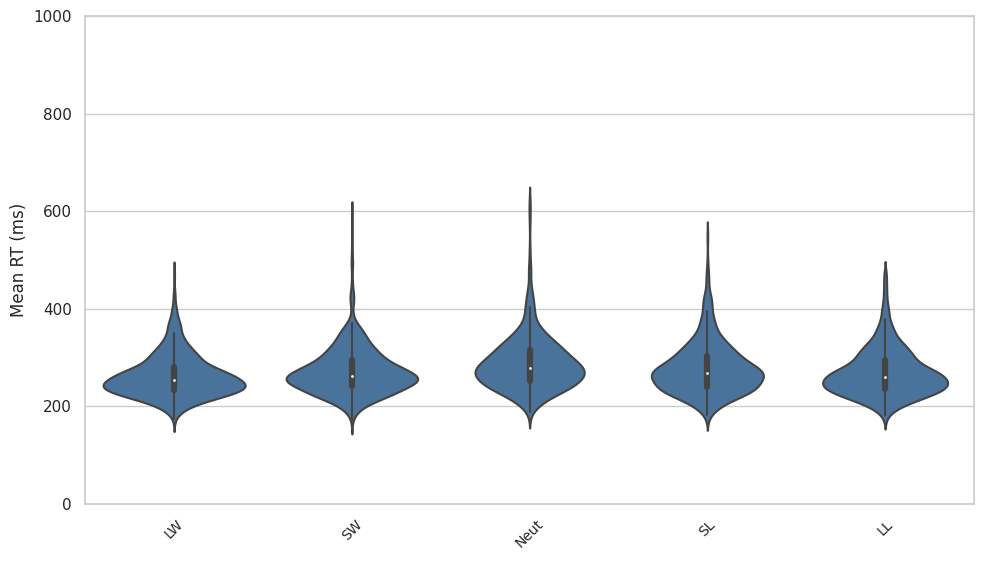

In [47]:
mean_mrt = final_mrt.groupby(['Condition', 'Subject'])['rt_correct'].mean().reset_index()
cue_order = ['LargeWin', 'SmallWin', 'Neutral', 'SmallLoss', 'LargeLoss']
renamed_cues = ['LW','SW','Neut','SL','LL'] # consistent with text in paper/contrasts

sns.set(style='whitegrid')  
plt.figure(figsize=(10, 6)) 
color_map = '#3c73a8'

sns.violinplot(x='Condition', y='rt_correct', order=cue_order, data=mean_mrt,
               showmeans=True, color=color_map, dodge = False)
plt.xlabel(' ')
plt.xticks(ticks=range(len(cue_order)),labels=renamed_cues, 
           rotation=45, fontsize=10)  
plt.ylabel('Mean RT (ms)')
plt.ylim(0,1000)
plt.tight_layout()
plt.savefig(f'{fig_out}/anticipation_cond-mrt.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [51]:
fbmrt_out = round(final_mrt.groupby(['Feedback.Response'])['rt_correct'].agg(['mean','std']),2)
round(final_mrt.groupby(['Run','Feedback.Response'])['rt_correct'].agg(['mean','std']),2)

mean     std
Run Feedback.Response                
1   LargeLossHit       240.47   31.27
    LargeLossMiss      320.13   94.21
    LargeWinHit        239.66   30.46
    LargeWinMiss       307.40  111.41
    NeutralHit         245.44   33.47
    NeutralMiss        343.33  138.77
    SmallLossHit       241.28   31.89
    SmallLossMiss      332.81  113.59
    SmallWinHit        242.72   31.91
    SmallWinMiss       320.90  100.42
2   LargeLossHit       242.85   36.91
    LargeLossMiss      334.56  108.13
    LargeWinHit        242.72   36.25
    LargeWinMiss       328.17  134.65
    NeutralHit         246.88   38.15
    NeutralMiss        356.25  113.08
    SmallLossHit       245.15   37.80
    SmallLossMiss      345.16  106.55
    SmallWinHit        245.72   37.48
    SmallWinMiss       333.77  112.55

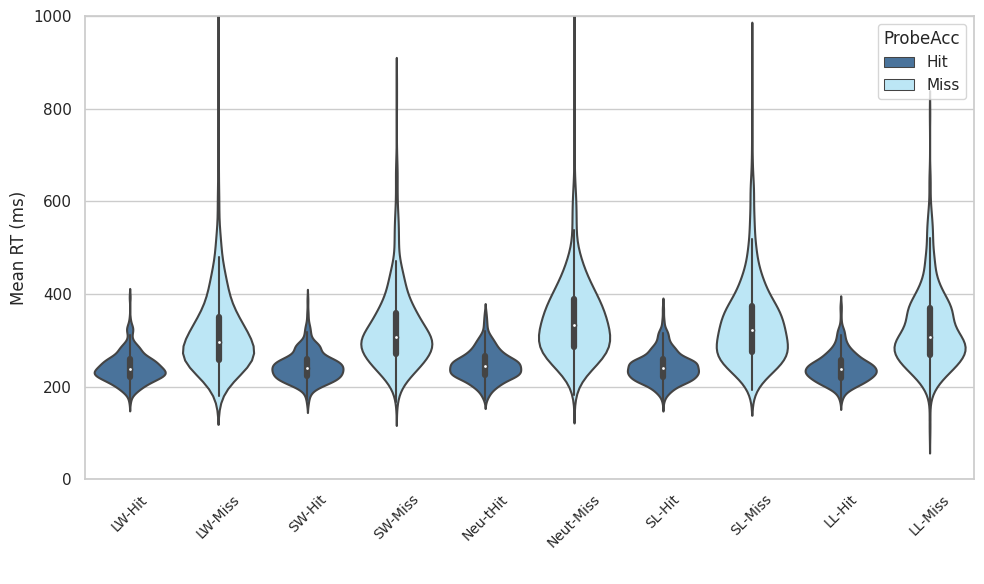

In [53]:
fb_mean_mrt = final_mrt.groupby(['Feedback.Response', 'Subject'])['rt_correct'].mean().reset_index()
fb_mean_mrt['ProbeAcc'] = fb_mean_mrt['Feedback.Response'].str.extract(r'(Hit|Miss)$')

# set labs
fb_order = ['LargeWinHit', 'LargeWinMiss', 'SmallWinHit', 'SmallWinMiss',
            'NeutralHit','NeutralMiss', 'SmallLossHit', 'SmallLossMiss', 'LargeLossHit', 'LargeLossMiss']
fb_relab = ['LW-Hit', 'LW-Miss', 'SW-Hit', 'SW-Miss',
            'Neu-tHit','Neut-Miss', 
            'SL-Hit', 'SL-Miss', 'LL-Hit', 'LL-Miss']

sns.set(style='whitegrid')  # Set the style for the plots
plt.figure(figsize=(10, 6))
# set colors/mappings
hit_color = '#3c73a8'
miss_color = '#B2EBFF'
color_map = {'Hit': hit_color, 'Miss': miss_color}

# plt
sns.violinplot(x='Feedback.Response', y='rt_correct', order=fb_order, data=fb_mean_mrt,
               showmeans=True, hue='ProbeAcc', palette=color_map, dodge = False)
plt.xlabel(' ')
plt.xticks(ticks=range(len(fb_order)),labels=fb_relab, 
           rotation=45, fontsize=10)  
plt.ylim(0,1000)
plt.ylabel('Mean RT (ms)')
plt.tight_layout()
plt.savefig(f'{fig_out}/feedback_cond-mrt.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 6.2.1 Accuracy overall and across conditions

In [54]:
acc_out = round(final_acc.groupby(['Condition'])['prbacc'].agg(['mean','std']),2)
round(final_acc.groupby(['Run','Condition'])['prbacc'].agg(['mean','std']),2)

mean   std
Run Condition            
1   LargeLoss  0.60  0.14
    LargeWin   0.64  0.13
    Neutral    0.49  0.18
    SmallLoss  0.57  0.13
    SmallWin   0.58  0.13
2   LargeLoss  0.61  0.15
    LargeWin   0.63  0.14
    Neutral    0.45  0.18
    SmallLoss  0.55  0.14
    SmallWin   0.56  0.14

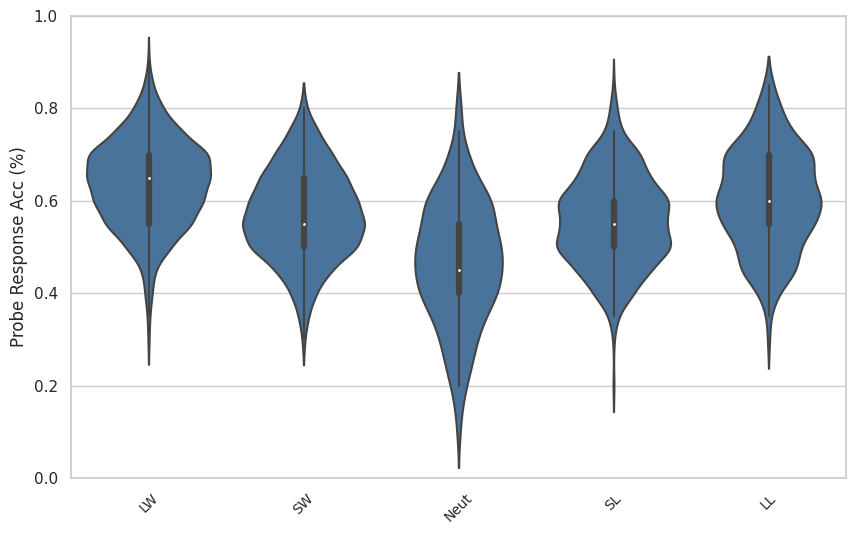

In [55]:
mean_prbacc = final_acc.groupby(['Condition', 'Subject'])['prbacc'].mean().reset_index()
cue_order = ['LargeWin', 'SmallWin', 'Neutral', 'SmallLoss', 'LargeLoss']
renamed_cues = ['LW','SW','Neut','SL','LL'] # consistent with text in paper/contrasts


sns.set(style='whitegrid')  
plt.figure(figsize=(10, 6)) 

sns.violinplot(x='Condition', y='prbacc', order=cue_order, data=mean_prbacc, 
               showmeans=True, color='#3c73a8', dodge = False)

plt.xlabel(' ')
plt.xticks(ticks=range(len(cue_order)),labels=renamed_cues, 
           rotation=45, fontsize=10) 
plt.ylabel('Probe Response Acc (%)')
plt.ylim(0,1)
plt.savefig(f'{fig_out}/anticipation_cond-probeacc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [56]:
round(final_acc.groupby(['Run','Feedback.Response'])['prbacc'].agg(['mean','std']),2)

mean  std
Run Feedback.Response           
1   LargeLossHit        1.0  0.0
    LargeLossMiss       0.0  0.0
    LargeWinHit         1.0  0.0
    LargeWinMiss        0.0  0.0
    NeutralHit          1.0  0.0
    NeutralMiss         0.0  0.0
    SmallLossHit        1.0  0.0
    SmallLossMiss       0.0  0.0
    SmallWinHit         1.0  0.0
    SmallWinMiss        0.0  0.0
2   LargeLossHit        1.0  0.0
    LargeLossMiss       0.0  0.0
    LargeWinHit         1.0  0.0
    LargeWinMiss        0.0  0.0
    NeutralHit          1.0  0.0
    NeutralMiss         0.0  0.0
    SmallLossHit        1.0  0.0
    SmallLossMiss       0.0  0.0
    SmallWinHit         1.0  0.0
    SmallWinMiss        0.0  0.0

## 6.3.1 `Cue Condition`: Acc / MRT Effect Sizes

In [156]:
results = []

conditions = cue_order
comb_pairs = list(combinations(conditions, 2))

for pair_comp in comb_pairs:
    acc_mean1 = acc_out.loc[pair_comp[0]]['mean']
    acc_std1 = acc_out.loc[pair_comp[0]]['std']
    acc_mean2 = acc_out.loc[pair_comp[1]]['mean']
    acc_std2 = acc_out.loc[pair_comp[1]]['std']

    acc_deffect = round(cohens_d(acc_mean1, acc_std1, acc_mean2, acc_std2, n), 2)

    mrt_mean1 = mrt_out.loc[pair_comp[0]]['mean']
    mrt_std1 = mrt_out.loc[pair_comp[0]]['std']
    mrt_mean2 = mrt_out.loc[pair_comp[1]]['mean']
    mrt_std2 = mrt_out.loc[pair_comp[1]]['std']

    mrt_deffect = round(cohens_d(mrt_mean1, mrt_std1, mrt_mean2, mrt_std2, n), 2)
    
    # Append the results to the list
    results.append({
        'a_condition': pair_comp[0],
        'b_condition': pair_comp[1],
        'acc_mean.a': acc_mean1,
        'acc_mean.b': acc_mean2,
        'acc_std.a': acc_std1,
        'acc_std.b': acc_std2,
        'acc_cohensd': acc_deffect,
        'mrt_mean.a': mrt_mean1,
        'mrt_mean.b': mrt_mean2,
        'mrt_std.a': mrt_std1,
        'mrt_std.b': mrt_std2,
        'mrt_cohensd': mrt_deffect
    })

cuecond_cohensd = pd.DataFrame(results)

In [157]:
cuecond_cohensd

a_condition b_condition  acc_mean.a  acc_mean.b  acc_std.a  acc_std.b  \
0    LargeWin    SmallWin        0.64        0.57       0.13       0.13   
1    LargeWin     Neutral        0.64        0.47       0.13       0.18   
2    LargeWin   SmallLoss        0.64        0.56       0.13       0.14   
3    LargeWin   LargeLoss        0.64        0.60       0.13       0.15   
4    SmallWin     Neutral        0.57        0.47       0.13       0.18   
5    SmallWin   SmallLoss        0.57        0.56       0.13       0.14   
6    SmallWin   LargeLoss        0.57        0.60       0.13       0.15   
7     Neutral   SmallLoss        0.47        0.56       0.18       0.14   
8     Neutral   LargeLoss        0.47        0.60       0.18       0.15   
9   SmallLoss   LargeLoss        0.56        0.60       0.14       0.15   

   acc_cohensd  mrt_mean.a  mrt_mean.b  mrt_std.a  mrt_std.b  mrt_cohensd  
0         0.54      262.39      272.32      48.76      54.93        -0.19  
1         1.08      262.39      288.67      48.76      62.92        -0.47  
2         0.59      262.39      278.54      48.76      59.55        -0.30  
3         0.28      262.39      269.61      48.76      54.07        -0.14  
4         0.64      272.32      288.67      54.93      62.92        -0.28  
5         0.07      272.32      278.54      54.93      59.55        -0.11  
6        -0.21      272.32      269.61      54.93      54.07         0.05  
7        -0.56      288.67      278.54      62.92      59.55         0.17  
8        -0.78      288.67      269.61      62.92      54.07         0.32  
9        -0.28      278.54      269.61      59.55      54.07         0.16

## 6.3.2 `Feedback Condition`: Acc / MRT Effect Sizes

In [158]:
results = []

conditions = ['LargeWinHit', 'LargeWinMiss','NeutralHit','NeutralMiss', 'LargeLossHit', 'LargeLossMiss']
comb_pairs = list(combinations(conditions, 2))

for pair_comp in comb_pairs:
    mrt_mean1 = fbmrt_out.loc[pair_comp[0]]['mean']
    mrt_std1 = fbmrt_out.loc[pair_comp[0]]['std']
    mrt_mean2 = fbmrt_out.loc[pair_comp[1]]['mean']
    mrt_std2 = fbmrt_out.loc[pair_comp[1]]['std']

    mrt_deffect = round(cohens_d(mrt_mean1, mrt_std1, mrt_mean2, mrt_std2, n), 2)
    
    # Append the results to the list
    results.append({
        'a_condition': pair_comp[0],
        'b_condition': pair_comp[1],
        'mrt_mean.a': mrt_mean1,
        'mrt_mean.b': mrt_mean2,
        'mrt_std.a': mrt_std1,
        'mrt_std.b': mrt_std2,
        'mrt_cohensd': mrt_deffect
    })

fdcond_cohensd = pd.DataFrame(results)